# **ACCT 745 Midterm Project: Accounts Receivables Provision**
## **Documented Workflow for Python Scripts**
## **Author:** *Long Dang*

## ***I. Data Inspection & Dictionary Creation***

### **1. Setup & Imports**
#### - Imports core libraries
#### - Sets display options for cleaner tables in Jupyter
#### - Defines your Windows base path (edit if your folder changes)

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt   # <- replace `import plt`
import warnings                   # <- new import

from IPython.display import display, Markdown

# Pretty display in Jupyter
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 30)

# Use the current working directory (project root / notebook folder)
BASE_DIR = Path(".")

# Filenames only (no absolute paths needed)
FILES = {
    "provisions": "provisions for acct receivables.csv",
    "industry_data": "industry_data.csv",
    "industry_names": "industry names.csv",
}

def section(title: str, subtitle: str = ""):
    """Helper to render a nice section header in Jupyter."""
    display(Markdown(f"## {title}"))
    if subtitle:
        display(Markdown(subtitle))

### **2. Robust CSV Loader**
#### - Reads CSVs using a few common encodings
#### - Raises a clear error if a file is missing

In [2]:
import re

def _normalize_name(s: str) -> str:
    """Lowercase + remove spaces/underscores/dashes for matching."""
    return re.sub(r"[\s_\-]+", "", s).lower()

def find_file(filename: str, base: Path = BASE_DIR) -> Path:
    """
    Try exact path first; otherwise search the project tree for a close match.
    Priority: exact name -> normalized exact -> normalized contains.
    """
    cand = base / filename
    if cand.exists():
        return cand

    target_norm = _normalize_name(filename)
    # Build an index of CSVs (one pass)
    csv_paths = list(base.rglob("*.csv"))

    # 1) exact filename (case-insensitive) in same folder tree
    for p in csv_paths:
        if p.name.lower() == filename.lower():
            return p

    # 2) normalized exact match
    for p in csv_paths:
        if _normalize_name(p.name) == target_norm:
            return p

    # 3) normalized contains (last resort)
    for p in csv_paths:
        if target_norm in _normalize_name(p.name):
            return p

    raise FileNotFoundError(f"Could not locate '{filename}' under {base.resolve()}")

def safe_read_csv(path: Path) -> pd.DataFrame:
    """Robust CSV reader with common encodings."""
    for enc in ("utf-8-sig", "utf-8", "cp1252", "latin-1"):
        try:
            return pd.read_csv(path, low_memory=False, encoding=enc)
        except UnicodeDecodeError:
            continue
    # Final attempt without explicit encoding
    return pd.read_csv(path, low_memory=False)

### **3. Load Datasets & Basic Shape Check**
#### - Loads all three datasets
#### - Shows row/column counts so you know what you’re working with

In [3]:
section("Load datasets", "Locate files in the project and verify shapes.")

prov_path = find_file(FILES["provisions"])
indd_path = find_file(FILES["industry_data"])
indn_path = find_file(FILES["industry_names"])

display(Markdown("**Resolved paths**"))
display(pd.DataFrame({
    "name": ["provisions", "industry_data", "industry_names"],
    "path": [str(prov_path), str(indd_path), str(indn_path)]
}))

provisions    = safe_read_csv(prov_path)
industry_data = safe_read_csv(indd_path)
industry_names= safe_read_csv(indn_path)

shape_tbl = pd.DataFrame({
    "table": ["provisions", "industry_data", "industry_names"],
    "rows":  [provisions.shape[0], industry_data.shape[0], industry_names.shape[0]],
    "cols":  [provisions.shape[1], industry_data.shape[1], industry_names.shape[1]],
})
display(shape_tbl)

## Load datasets

Locate files in the project and verify shapes.

**Resolved paths**

,name,path
0,provisions,(1) Accounts Receivables Provision Data\provis...
1,industry_data,(1) Accounts Receivables Provision Data\indust...
2,industry_names,(1) Accounts Receivables Provision Data\indust...


,table,rows,cols
0,provisions,323475,27
1,industry_data,47767,2
2,industry_names,46,2


### **4. Columns & Dtype Preview**
#### - Lists columns and pandas dtypes for each dataset

In [4]:
section("Columns & dtypes — quick peek")

def cols_dtypes(df: pd.DataFrame, name: str):
    out = pd.DataFrame({"column": df.columns, "dtype": [str(t) for t in df.dtypes]})
    display(Markdown(f"**{name}**")); display(out)

cols_dtypes(provisions, "provisions")
cols_dtypes(industry_data, "industry_data")
cols_dtypes(industry_names, "industry_names")

## Columns & dtypes — quick peek

**provisions**

,column,dtype
0,company_code,int64
1,date_var,object
2,sales,float64
3,interest_expense,float64
4,provision_bad_receivables,float64
5,writeoff_bad_receivables,float64
6,cogs,float64
7,net_income,float64
8,ebidta,float64
9,ebit,float64


**industry_data**

,column,dtype
0,new_industry_code,int64
1,company_id,int64


**industry_names**

,column,dtype
0,Industry Name,object
1,Industry code,int64


### **5. Parse Dates & Quick Date Profile**
#### - Parses 'date_var' → 'date', adds 'year'/'quarter'
#### - Shows reporting month distribution (e.g., Dec vs Jun)

In [5]:
section("Date parsing & distribution")

def parse_stata_like_date(val):
    if pd.isna(val): return pd.NaT
    s = str(val).strip().lower()
    m = re.match(r"^(\d{1,2})([a-z]{3})(\d{4})$", s)
    if not m: return pd.NaT
    day, mon, year = m.groups()
    try:
        return pd.to_datetime(f"{day}-{mon}-{year}", format="%d-%b-%Y")
    except Exception:
        return pd.NaT

if "date_var" in provisions.columns:
    provisions["date"] = provisions["date_var"].map(parse_stata_like_date)
    provisions["year"] = provisions["date"].dt.year
    provisions["quarter"] = provisions["date"].dt.quarter

    display(provisions[["date_var","date","year","quarter"]].head(8))

    month_share = provisions["date"].dt.month.value_counts(normalize=True).sort_index() * 100
    display(Markdown("**Month distribution of reporting dates (% of rows):**"))
    display(month_share.rename("percent").round(2).to_frame())
else:
    display(Markdown("> `date_var` not found in provisions — skip parsing."))

## Date parsing & distribution

,date_var,date,year,quarter
0,31dec2012,2012-12-31,2012,4
1,31dec2013,2013-12-31,2013,4
2,31dec2014,2014-12-31,2014,4
3,31dec2015,2015-12-31,2015,4
4,31dec2016,2016-12-31,2016,4
5,31dec2017,2017-12-31,2017,4
6,31dec2018,2018-12-31,2018,4
7,31dec2019,2019-12-31,2019,4


**Month distribution of reporting dates (% of rows):**

,percent
date,
6,1.17
12,98.83


### **6. Duplicate Check at the Grain**
#### - Detects duplicates at (company_code, date) grain

In [6]:
section("Duplicate check at (company_code, date)")

if {"company_code","date"}.issubset(provisions.columns):
    dup_mask = provisions.duplicated(subset=["company_code","date"], keep=False)
    n_dupe_rows = int(dup_mask.sum())
    dupe_pairs = provisions.loc[dup_mask, ["company_code","date"]].drop_duplicates()

    display(pd.DataFrame({
        "duplicate_rows": [n_dupe_rows],
        "duplicate_pairs": [dupe_pairs.shape[0]],
    }))

    if n_dupe_rows:
        display(Markdown("**Sample duplicated pairs:**"))
        display(dupe_pairs.sort_values(["company_code","date"]).head(12))
else:
    display(Markdown("> Keys `company_code` and/or `date` not available yet."))

## Duplicate check at (company_code, date)

,duplicate_rows,duplicate_pairs
0,12,6


**Sample duplicated pairs:**

,company_code,date
21152,139618,2016-06-30
21157,139618,2021-06-30
93963,271367,2014-06-30
113706,313707,2019-06-30
175703,471018,2013-06-30
290797,656899,2014-06-30


### **7. AR-Related Columns (sanity)**
#### - Enumerates receivables / aging / provisioning columns

In [7]:
section("AR-related columns (provisions)")
ar_cols = [c for c in provisions.columns if ("receivable" in c.lower()) or c.lower().startswith("accounts_receivables")]
display(pd.DataFrame({"ar_related_columns": ar_cols}))

## AR-related columns (provisions)

,ar_related_columns
0,provision_bad_receivables
1,writeoff_bad_receivables
2,accounts_receivables
3,receivables_morethan6m
4,secured_receivables_morethan6m
5,unsec_receivables_morethan6m
6,receivables_lessthan6m
7,secured_receivables_lessthan6m
8,unsec_receivables_lessthan6m


### **8. Data Dictionaries (all tables)**
#### - Shows dtype, missingness, # uniques, and example values
#### - Sorted by % missing to surface issues quickly

In [8]:
section("Data dictionaries (inspection-first view)",
        "Sorted by % missing (highest first). Adjust `max_rows_to_show` if you want more/less.")

def build_data_dictionary(df: pd.DataFrame, table_name: str) -> pd.DataFrame:
    d = pd.DataFrame({
        "table": table_name,
        "column": df.columns,
        "dtype_inferred": [str(t) for t in df.dtypes],
        "n_non_null": df.notna().sum().values,
        "n_null": df.isna().sum().values,
        "pct_missing": (df.isna().mean().values * 100).round(2),
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
    })
    examples = []
    for c in df.columns:
        vals = df[c].dropna().head(3).tolist()
        examples.append(", ".join(map(lambda x: str(x)[:60], vals)))
    d["examples"] = examples
    return d.sort_values("pct_missing", ascending=False).reset_index(drop=True)

max_rows_to_show = 30

dict_prov = build_data_dictionary(provisions, "provisions")
dict_indd = build_data_dictionary(industry_data, "industry_data")
dict_indn = build_data_dictionary(industry_names, "industry_names")

display(Markdown("**provisions — top rows by % missing:**"))
display(dict_prov.head(max_rows_to_show))

display(Markdown("**industry_data — all columns:**"))
display(dict_indd)

display(Markdown("**industry_names — all columns:**"))
display(dict_indn)

## Data dictionaries (inspection-first view)

Sorted by % missing (highest first). Adjust `max_rows_to_show` if you want more/less.

**provisions — top rows by % missing:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,provisions,secured_receivables_morethan6m,float64,4320,319155,98.66,2082,"1.544, 0.0478, 0.0213"
1,provisions,secured_receivables_lessthan6m,float64,9531,313944,97.05,5996,"1.3731, 1.362, 1.3499"
2,provisions,provision_bad_receivables,float64,34577,288898,89.31,8102,"0.0901, 0.0574, 0.0608"
3,provisions,writeoff_bad_receivables,float64,41433,282042,87.19,5578,"0.0074, 0.0016, 0.0016"
4,provisions,unsec_receivables_morethan6m,float64,113828,209647,64.81,21129,"0.0386, 0.0426, 0.04"
5,provisions,receivables_morethan6m,float64,114561,208914,64.58,21360,"0.0386, 0.0426, 0.04"
6,provisions,investment_asset,float64,160944,162531,50.25,51451,"0.2106, 1.1323, 1.1145"
7,provisions,unsec_receivables_lessthan6m,float64,171457,152018,47.00,50624,"0.7392, 0.4154, 0.4966"
8,provisions,receivables_lessthan6m,float64,173419,150056,46.39,51516,"0.7392, 0.4154, 0.4966"
9,provisions,inventories,float64,205738,117737,36.40,70456,"9.5523, 8.1464, 9.4798"


**industry_data — all columns:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,industry_data,new_industry_code,int64,47767,0,0.0,44,"101, 101, 101"
1,industry_data,company_id,int64,47767,0,0.0,47767,"173839, 400434, 766803"


**industry_names — all columns:**

,table,column,dtype_inferred,n_non_null,n_null,pct_missing,n_unique,examples
0,industry_names,Industry Name,object,46,0,0.0,46,"Agriculture, Mining, quarrying, and extraction..."
1,industry_names,Industry code,int64,46,0,0.0,44,"101, 102, 103"


### **9. Numeric Summary (provisions)**
#### - Descriptive stats for numeric columns (incl. extreme percentiles)

In [9]:
section("Numeric summary — provisions (selected percentiles)")

num_cols = provisions.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    describe_tbl = provisions[num_cols].describe(
        percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    ).T
    display(describe_tbl)
else:
    display(Markdown("> No numeric columns detected in `provisions`."))

## Numeric summary — provisions (selected percentiles)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
company_code,323475.0,406680.623442,178084.926057,100003.0000,107065.000000,131820.000000,245665.5000,436767.0000,528016.000000,672783.000000,747940.000000,792720.0000
sales,252550.0,79.198587,864.674015,-11.3747,0.002700,0.019200,0.9191,6.7952,31.005375,222.079580,1103.306178,97142.1480
interest_expense,213795.0,3.581586,30.391607,-68.4728,0.001300,0.002000,0.0334,0.2045,0.967200,9.941890,61.093998,3994.9006
provision_bad_receivables,34577.0,1.403610,15.918423,-0.1063,0.000000,0.001300,0.0165,0.0740,0.326700,3.381980,21.547020,1684.4496
writeoff_bad_receivables,41433.0,0.465888,5.825427,-0.0131,0.000000,0.000000,0.0052,0.0230,0.103000,0.992800,6.630348,578.5004
cogs,323475.0,47.767087,614.598849,-887.7171,0.000000,0.000000,0.0387,1.8797,14.748400,133.686847,682.911453,77870.7970
net_income,304678.0,1.953486,72.107962,-9836.0204,-31.583529,-3.354130,-0.0161,0.0320,0.575600,9.314095,57.215990,5286.3800
ebidta,304844.0,9.522388,118.242600,-5906.4676,-7.032971,-0.379200,0.0067,0.3240,2.431700,25.851675,149.407940,11788.6076
ebit,304844.0,6.333430,92.844338,-6291.3059,-14.964783,-1.199240,0.0000,0.1803,1.665100,19.017055,111.053969,8239.0837
debt_total,250309.0,41.490930,399.517366,-201.5009,0.002000,0.016400,0.3691,2.2175,10.579500,110.580720,656.865000,44151.8237


### **10. What we learned & next step** 
#### - Summarizes this inspection pass
#### - Points to the cleaning/summary step next

In [10]:
summary_bullets = """
- **Files located** via `find_file()` and loaded from the current project (no absolute paths).
- **Dates parsed** into `date`, `year`, `quarter`; month distribution reviewed.
- **Duplicates** at (company_code, date) identified for resolution in cleaning.
- **AR fields** confirmed (total, >6m, <6m, secured/unsecured, provisions, write-offs).
- **Data dictionaries** surfaced inline for all tables; **numeric ranges** reviewed.
**Next:** run the Cleaning & Statistics Summary notebook cells to deduplicate, join industry, and compute AR metrics/flags.
"""
section("Inspection summary", summary_bullets)

## Inspection summary


- **Files located** via `find_file()` and loaded from the current project (no absolute paths).
- **Dates parsed** into `date`, `year`, `quarter`; month distribution reviewed.
- **Duplicates** at (company_code, date) identified for resolution in cleaning.
- **AR fields** confirmed (total, >6m, <6m, secured/unsecured, provisions, write-offs).
- **Data dictionaries** surfaced inline for all tables; **numeric ranges** reviewed.
**Next:** run the Cleaning & Statistics Summary notebook cells to deduplicate, join industry, and compute AR metrics/flags.


## ***II. Data Cleaning, Transformation, and Summary***

### **1. Load cleaned datasets and implement settings**
#### - Loads the three CSVs with a robust reader
#### - Displays shapes so you can verify inputs

In [11]:
BASE_DIR = Path(r"F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data")

FILES = {
    "provisions": "provisions for acct receivables.csv",
    "industry_data": "industry_data.csv",
    "industry_names": "industry names.csv",
}

OUT_DIR = BASE_DIR / "_output_clean"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Winsorization & materiality configuration
WINSOR_LOWER = 0.01    # 1st percentile
WINSOR_UPPER = 0.99    # 99th percentile
AR_MATERIAL_QUANTILE = 0.10  # 10th percentile of positive AR


### **2. Load Helpers**

In [12]:
def safe_read_csv(path: Path) -> pd.DataFrame:
    """Robust CSV reader with common encodings."""
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    for enc in ("utf-8-sig", "utf-8", "cp1252", "latin-1"):
        try:
            return pd.read_csv(path, low_memory=False, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path, low_memory=False)


def parse_stata_like_date(val):
    """Parse '31dec2019' → Timestamp('2019-12-31'); else NaT."""
    if pd.isna(val):
        return pd.NaT
    s = str(val).strip().lower()
    m = re.match(r"^(\d{1,2})([a-z]{3})(\d{4})$", s)
    if not m:
        return pd.NaT
    day, mon, year = m.groups()
    try:
        return pd.to_datetime(f"{day}-{mon}-{year}", format="%d-%b-%Y")
    except Exception:
        return pd.NaT


def winsorize_series(s: pd.Series,
                     lower: float = WINSOR_LOWER,
                     upper: float = WINSOR_UPPER) -> pd.Series:
    """
    Winsorize a numeric Series at given lower/upper quantiles.
    Operates only on finite, non-null values; others are left as-is.
    """
    s = pd.to_numeric(s, errors="coerce")
    out = s.copy()
    mask = out.notna() & np.isfinite(out)
    if not mask.any():
        return out

    clean = out[mask]
    q_low = clean.quantile(lower)
    q_high = clean.quantile(upper)

    # If quantiles are not defined (e.g., too few obs), return as-is
    if pd.isna(q_low) or pd.isna(q_high):
        return out

    out.loc[mask & (out < q_low)] = q_low
    out.loc[mask & (out > q_high)] = q_high
    return out


### **3. CLEANING / MERGE UTILS & CONSTANTS**


In [13]:
AR_FIELDS = [
    "accounts_receivables",
    "receivables_morethan6m",
    "secured_receivables_morethan6m",
    "unsec_receivables_morethan6m",
    "receivables_lessthan6m",
    "secured_receivables_lessthan6m",
    "unsec_receivables_lessthan6m",
    "provision_bad_receivables",
    "writeoff_bad_receivables",
]


def dedup_at_company_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop duplicate rows at the (company_code, date) grain using:
      1) more non-null AR fields,
      2) higher sales,
      3) first occurrence as final tiebreaker.
    """
    df = df.copy()
    # Ensure AR_FIELDS exist
    for c in AR_FIELDS:
        if c not in df.columns:
            df[c] = np.nan

    df["_nn_ar"] = df[AR_FIELDS].notna().sum(axis=1)
    df["_sales_tie"] = pd.to_numeric(df["sales"], errors="coerce").fillna(-np.inf)

    df = df.sort_values(
        ["company_code", "date", "_nn_ar", "_sales_tie"],
        ascending=[True, True, False, False]
    )
    out = df.drop_duplicates(subset=["company_code", "date"], keep="first").copy()
    out.drop(columns=["_nn_ar", "_sales_tie"], inplace=True, errors="ignore")
    return out


def compute_metrics_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute descriptive/diagnostic metrics used in AR/provisioning analysis,
    with:
      - materiality filter on AR (to avoid tiny-denominator distortions),
      - winsorization of key ratios (stored in *_w columns).
    """
    df = df.copy()

    # --- Ensure key numeric columns are numeric
    for col in [
        "sales", "accounts_receivables", "provision_bad_receivables",
        "writeoff_bad_receivables", "current_asset", "current_liabilities",
        "debt_total", "total_asset", "net_income", "cfo",
        "receivables_morethan6m", "receivables_lessthan6m"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # --- AR materiality threshold (10th percentile of positive AR)
    ar_pos_mask = df["accounts_receivables"] > 0
    if ar_pos_mask.any():
        ar_thresh = df.loc[ar_pos_mask, "accounts_receivables"].quantile(AR_MATERIAL_QUANTILE)
    else:
        ar_thresh = np.nan

    df["ar_material_flag"] = False
    if not np.isnan(ar_thresh):
        df["ar_material_flag"] = (
            (df["accounts_receivables"] >= ar_thresh) &
            (df["accounts_receivables"] > 0) &
            (df["sales"] > 0)
        )

    print(f"AR materiality threshold (q{AR_MATERIAL_QUANTILE:.2f} of positive AR): {ar_thresh:,.4f}")

    idx = df.index

    # --- DSO & AR turnover (only for material AR & positive sales)
    dso_raw = pd.Series(np.nan, index=idx, dtype="float64")
    ar_turnover_raw = pd.Series(np.nan, index=idx, dtype="float64")

    mask_dso = df["ar_material_flag"]
    dso_raw[mask_dso] = 365 * df.loc[mask_dso, "accounts_receivables"] / df.loc[mask_dso, "sales"]
    ar_turnover_raw[mask_dso] = df.loc[mask_dso, "sales"] / df.loc[mask_dso, "accounts_receivables"]

    # raw + winsorized
    df["dso_approx"] = dso_raw
    df["ar_turnover"] = ar_turnover_raw
    df["dso_approx_w"] = winsorize_series(dso_raw)
    df["ar_turnover_w"] = winsorize_series(ar_turnover_raw)

    # --- Provision & write-off rates (only for material AR)
    prov_rate_raw = pd.Series(np.nan, index=idx, dtype="float64")
    writeoff_rate_raw = pd.Series(np.nan, index=idx, dtype="float64")

    mask_ar_ratio = ar_pos_mask & (df["accounts_receivables"] >= ar_thresh)
    prov_rate_raw[mask_ar_ratio] = (
        df.loc[mask_ar_ratio, "provision_bad_receivables"] /
        df.loc[mask_ar_ratio, "accounts_receivables"]
    )
    writeoff_rate_raw[mask_ar_ratio] = (
        df.loc[mask_ar_ratio, "writeoff_bad_receivables"] /
        df.loc[mask_ar_ratio, "accounts_receivables"]
    )

    df["prov_rate"] = prov_rate_raw
    df["writeoff_rate"] = writeoff_rate_raw
    df["prov_rate_w"] = winsorize_series(prov_rate_raw)
    df["writeoff_rate_w"] = winsorize_series(writeoff_rate_raw)

    # --- Liquidity & leverage ratios (raw + winsorized)
    liq_raw = pd.Series(np.nan, index=idx, dtype="float64")
    mask_cr = df["current_liabilities"] > 0
    liq_raw[mask_cr] = df.loc[mask_cr, "current_asset"] / df.loc[mask_cr, "current_liabilities"]
    df["liq_current_ratio"] = liq_raw
    df["liq_current_ratio_w"] = winsorize_series(liq_raw)

    lev_raw = pd.Series(np.nan, index=idx, dtype="float64")
    mask_lev = df["total_asset"] > 0
    lev_raw[mask_lev] = df.loc[mask_lev, "debt_total"] / df.loc[mask_lev, "total_asset"]
    df["lev_debt_to_assets"] = lev_raw
    df["lev_debt_to_assets_w"] = winsorize_series(lev_raw)

    # --- Earnings quality flag: NI>0 & CFO<0
    df["ni_pos_cfo_neg_flag"] = np.where(
        (df["net_income"] > 0) & (df["cfo"] < 0),
        1,
        0
    )

    # --- AR composition integrity: (>6m + <6m) ≈ total AR (within 1% tolerance)
    a = df["receivables_morethan6m"].fillna(0)
    b = df["receivables_lessthan6m"].fillna(0)
    df["ar_bucket_sum"] = a + b

    mask_eval = df["accounts_receivables"].notna() & df["ar_bucket_sum"].notna()
    df["ar_comp_ok"] = np.nan
    df.loc[mask_eval, "ar_comp_ok"] = np.isclose(
        df.loc[mask_eval, "accounts_receivables"],
        df.loc[mask_eval, "ar_bucket_sum"],
        rtol=0.01,
        atol=1e-6
    )

    return df


def summarize_overall(df: pd.DataFrame) -> pd.DataFrame:
    """Overall numeric summary (count, mean, std, percentiles) for quick QA."""
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return pd.DataFrame()
    desc = df[num_cols].describe(
        percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    ).T
    return desc


def summarize_by_industry_year(df: pd.DataFrame) -> pd.DataFrame:
    """
    Industry × Year profile: medians and coverage rates for key variables.
    Uses winsorized ratios (dso_approx_w, ar_turnover_w, prov_rate_w, writeoff_rate_w).
    """
    grouped = (
        df.groupby(["industry_code", "industry_name", "year"], dropna=False)
          .agg(
              n_obs=("company_code", "size"),
              n_companies=("company_code", "nunique"),
              med_sales=("sales", "median"),
              med_ar=("accounts_receivables", "median"),
              med_ar_turnover=("ar_turnover_w", "median"),
              med_dso=("dso_approx_w", "median"),
              med_prov_rate=("prov_rate_w", "median"),
              med_writeoff_rate=("writeoff_rate_w", "median"),
              prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
              writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
              ar_comp_ok_rate=("ar_comp_ok", lambda s: pd.to_numeric(s, errors="coerce").mean()),
              ni_pos_cfo_neg_rate=("ni_pos_cfo_neg_flag", "mean"),
          )
          .reset_index()
    )
    return grouped


### **4. MAIN CLEANING RUN**

In [14]:
def main():
    # ---- Load
    provisions = safe_read_csv(BASE_DIR / FILES["provisions"])
    industry_data = safe_read_csv(BASE_DIR / FILES["industry_data"])
    industry_names = safe_read_csv(BASE_DIR / FILES["industry_names"])

    print("Loaded:")
    print("  provisions:", provisions.shape)
    print("  industry_data:", industry_data.shape)
    print("  industry_names:", industry_names.shape)

    # ---- Parse date fields
    if "date_var" in provisions.columns:
        provisions["date"] = provisions["date_var"].map(parse_stata_like_date)
        provisions["year"] = provisions["date"].dt.year
        provisions["quarter"] = provisions["date"].dt.quarter

    # ---- Ensure required keys exist
    required_keys = {"company_code", "date"}
    if not required_keys.issubset(provisions.columns):
        raise KeyError(
            f"Provisions missing required keys {required_keys} — "
            f"found: {set(provisions.columns)}"
        )

    # ---- De-duplicate at grain (company_code, date)
    dupes = provisions.duplicated(subset=["company_code", "date"], keep=False).sum()
    print(f"Duplicate rows at (company_code, date) BEFORE dedup: {int(dupes)}")
    provisions = dedup_at_company_date(provisions)
    dupes_after = provisions.duplicated(subset=["company_code", "date"], keep=False).sum()
    print(f"Duplicate rows AFTER dedup: {int(dupes_after)}")
    print("Rows after dedup:", provisions.shape[0])

    # ---- Standardize industry tables
    ind_data = industry_data.rename(
        columns={"new_industry_code": "industry_code", "company_id": "company_code"}
    ).copy()
    ind_names = industry_names.rename(
        columns={"Industry code": "industry_code", "Industry Name": "industry_name"}
    ).copy()

    # dtypes
    ind_data["company_code"] = ind_data["company_code"].astype("Int64")
    ind_data["industry_code"] = ind_data["industry_code"].astype("Int64")
    ind_names["industry_code"] = ind_names["industry_code"].astype("Int64")

    # Handle duplicate industry_code labels (keep first as canonical name)
    before = ind_names.shape[0]
    ind_names = ind_names.drop_duplicates(subset=["industry_code"], keep="first").copy()
    after = ind_names.shape[0]
    if after < before:
        print(f"Deduped industry_names: kept {after} unique codes (from {before}).")

    # ---- Merge: provisions → industry code → industry name
    fact = (
        provisions.merge(ind_data, on="company_code", how="left")
                  .merge(ind_names, on="industry_code", how="left")
    )

    # ---- Exclude financial services from core analytical sample
    if "industry_name" in fact.columns:
        fs_mask = fact["industry_name"].str.lower().eq("financial services")
        n_fs = int(fs_mask.sum())
        if n_fs > 0:
            print(f"Excluding 'financial services' rows from core sample: {n_fs} rows dropped.")
            fact = fact.loc[~fs_mask].copy()
    else:
        print("Warning: 'industry_name' column missing; cannot exclude financial services.")

    # ---- Compute metrics & flags (with materiality + winsorization)
    fact = compute_metrics_flags(fact)

    # ---- Final sample info
    n_rows = fact.shape[0]
    n_companies = fact["company_code"].nunique()
    years_min = int(fact["year"].min())
    years_max = int(fact["year"].max())
    pct_dec = float((fact["date"].dt.month.eq(12)).mean() * 100)
    pct_jun = float((fact["date"].dt.month.eq(6)).mean() * 100)
    prov_cov = float(fact["provision_bad_receivables"].notna().mean() * 100)
    writeoff_cov = float(fact["writeoff_bad_receivables"].notna().mean() * 100)

    print("\nFinal sample (post-clean, excl. financial services):")
    print(f"  Rows: {n_rows:,}")
    print(f"  Companies: {n_companies:,}")
    print(f"  Years: {years_min}–{years_max}")
    print(f"  Date distribution: {pct_dec:.2f}% Dec 31, {pct_jun:.2f}% Jun 30")
    print(f"  Provision coverage: {prov_cov:.2f}% | Write-off coverage: {writeoff_cov:.2f}%")

    # ---- Summaries
    overall_numeric = summarize_overall(fact)
    by_industry_year = summarize_by_industry_year(fact)

    # ---- Save outputs
    fact_out = OUT_DIR / "_fact_cleaned_with_metrics.csv"
    overall_out = OUT_DIR / "_overall_numeric_summary.csv"
    prof_out = OUT_DIR / "_industry_year_profile.csv"

    fact.to_csv(fact_out, index=False)
    overall_numeric.to_csv(overall_out)
    by_industry_year.to_csv(prof_out, index=False)

    print("\nFiles written:")
    print(f"  Cleaned fact table: {fact_out}")
    print(f"  Overall numeric summary: {overall_out}")
    print(f"  Industry×Year profile: {prof_out}")

    # ---- Optional sanity snapshots
    fact.head(50).to_csv(OUT_DIR / "_sample_head_fact.csv", index=False)
    fact.tail(50).to_csv(OUT_DIR / "_sample_tail_fact.csv", index=False)


if __name__ == "__main__":
    pd.set_option("display.width", 160)
    pd.set_option("display.max_columns", 60)
    main()

Loaded:
  provisions: (323475, 27)
  industry_data: (47767, 2)
  industry_names: (46, 2)
Duplicate rows at (company_code, date) BEFORE dedup: 12
Duplicate rows AFTER dedup: 0
Rows after dedup: 323469
Deduped industry_names: kept 44 unique codes (from 46).
Excluding 'financial services' rows from core sample: 38375 rows dropped.
AR materiality threshold (q0.10 of positive AR): 0.0417


C:\Users\lilbu\AppData\Local\Temp\ipykernel_35292\1879443398.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask_eval, "ar_comp_ok"] = np.isclose(



Final sample (post-clean, excl. financial services):
  Rows: 285,094
  Companies: 34,791
  Years: 2012–2022
  Date distribution: 98.79% Dec 31, 1.21% Jun 30
  Provision coverage: 11.52% | Write-off coverage: 13.72%

Files written:
  Cleaned fact table: F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data\_output_clean\_fact_cleaned_with_metrics.csv
  Overall numeric summary: F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data\_output_clean\_overall_numeric_summary.csv
  Industry×Year profile: F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data\_output_clean\_industry_year_profile.csv


## ***III. Descriptive & Diagnostic Analytics***

### **A. Preconditions & helpers**
#### - Verifies that the cleaned/merged DataFrame `fact` exists (from the Cleaning step)
#### - Adds small helpers for display
#### - Implement settings for visuals

In [15]:
# =============
# 1) SETTINGS
# =============
BASE_DIR = Path(r"F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data")
CLEAN_DIR = BASE_DIR / "_output_clean"
ANALYSIS_DIR = BASE_DIR / "_output_analysis"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Core (non-financial) sample from the refined cleaning step
FACT_FILE = CLEAN_DIR / "_fact_cleaned_with_metrics.csv"

# ----------------------
# PLOT STYLE
# ----------------------
plt.rcParams.update({
    "figure.figsize": (12, 7),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# =====================
# 2) LOAD CLEANED DATA
# =====================
def load_fact(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(
            f"Cleaned file not found: {path}\n"
            f"Run the Cleaning, Transformation, and Summary script first."
        )
    return pd.read_csv(path, low_memory=False)

df = load_fact(FACT_FILE)

# Ensure expected columns exist (created in the cleaning step)
required_cols = {
    "company_code", "date", "year", "industry_code", "industry_name",
    "sales", "accounts_receivables", "receivables_morethan6m", "receivables_lessthan6m",
    "provision_bad_receivables", "writeoff_bad_receivables", "cfo", "net_income",
    # raw ratios
    "ar_turnover", "dso_approx", "prov_rate", "writeoff_rate",
    "liq_current_ratio", "lev_debt_to_assets",
    # winsorized ratios
    "dso_approx_w", "ar_turnover_w", "prov_rate_w", "writeoff_rate_w",
    "liq_current_ratio_w", "lev_debt_to_assets_w",
    # flags
    "ar_comp_ok", "ni_pos_cfo_neg_flag"
}
missing = required_cols.difference(df.columns)
if missing:
    raise KeyError(f"Missing expected columns in cleaned file: {missing}")

# Ensure types
if not np.issubdtype(df["year"].dtype, np.number):
    df["year"] = pd.to_numeric(df["year"], errors="coerce")

# If date was written as string, we don't strictly need to parse it here,
# but it doesn't hurt for potential extensions:
# df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Helper AR composition shares (only when AR > 0 to avoid weird ratios)
df["accounts_receivables"] = pd.to_numeric(df["accounts_receivables"], errors="coerce")
mask_ar_pos = df["accounts_receivables"] > 0

df["pct_over6m"] = np.nan
df.loc[mask_ar_pos, "pct_over6m"] = (
    df.loc[mask_ar_pos, "receivables_morethan6m"] /
    df.loc[mask_ar_pos, "accounts_receivables"]
)

df["pct_under6m"] = np.nan
df.loc[mask_ar_pos, "pct_under6m"] = (
    df.loc[mask_ar_pos, "receivables_lessthan6m"] /
    df.loc[mask_ar_pos, "accounts_receivables"]
)

# Filter helper for plotting (avoid +/- inf)
def finite_series(s: pd.Series):
    return s.replace([np.inf, -np.inf], np.nan)


### **B. DESCRIPTIVE SUMMARY ARTIFACTS**
#### 1. Calculation

In [16]:
# Overall KPIs — use winsorized DSO & AR turnover for stability
overall = pd.Series({
    "rows": len(df),
    "companies": df["company_code"].nunique(),
    "years_min": int(df["year"].min()),
    "years_max": int(df["year"].max()),
    "median_dso_w": finite_series(df["dso_approx_w"]).median(skipna=True),
    "median_ar_turnover_w": finite_series(df["ar_turnover_w"]).median(skipna=True),
    "prov_coverage_share": df["provision_bad_receivables"].notna().mean(),
    "writeoff_coverage_share": df["writeoff_bad_receivables"].notna().mean(),
    "ar_comp_ok_rate": pd.to_numeric(df["ar_comp_ok"], errors="coerce").mean(),
    "ni_pos_cfo_neg_rate": df["ni_pos_cfo_neg_flag"].mean(),
}).to_frame("value")
overall.to_csv(ANALYSIS_DIR / "_overall_kpis.csv")

# Industry × Year medians / coverage (using winsorized DSO & turnover)
indyr_medians = (
    df.groupby(["industry_code", "industry_name", "year"], dropna=False)
      .agg(
          med_sales=("sales", "median"),
          med_ar=("accounts_receivables", "median"),
          med_dso_w=("dso_approx_w", "median"),
          med_ar_turnover_w=("ar_turnover_w", "median"),
          med_pct_over6m=("pct_over6m", "median"),
          prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
          writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
      )
      .reset_index()
)
indyr_medians.to_csv(ANALYSIS_DIR / "_indyear_medians_coverage.csv", index=False)


#### 2. Figures and Visualizations

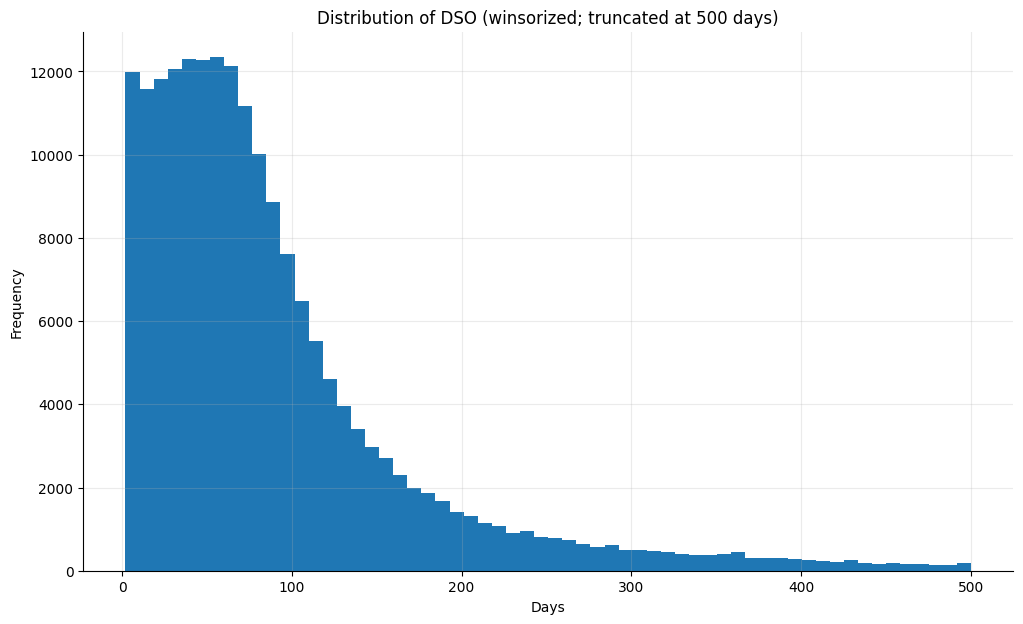

<Figure size 1200x700 with 0 Axes>

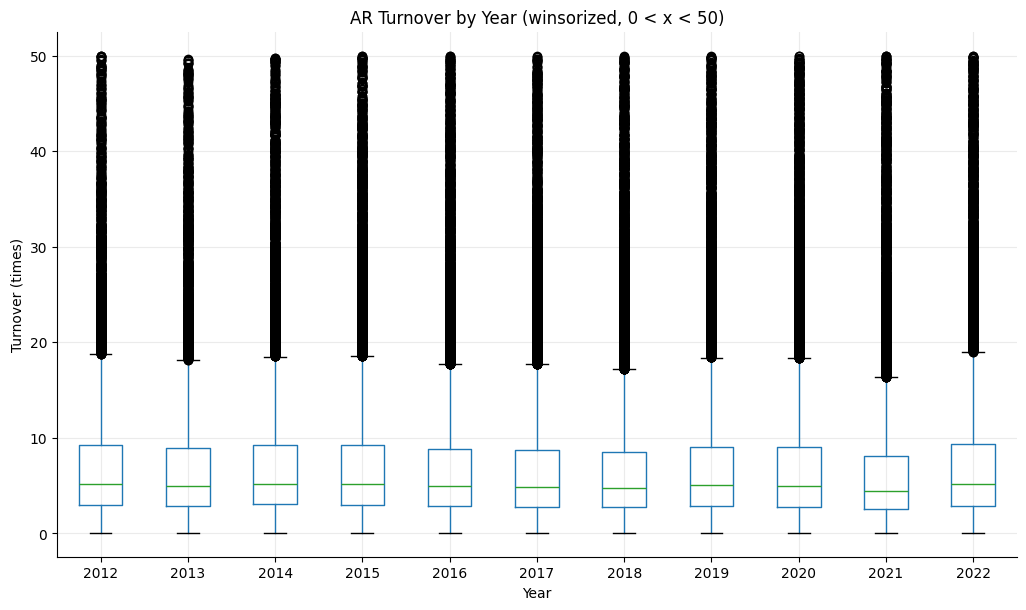

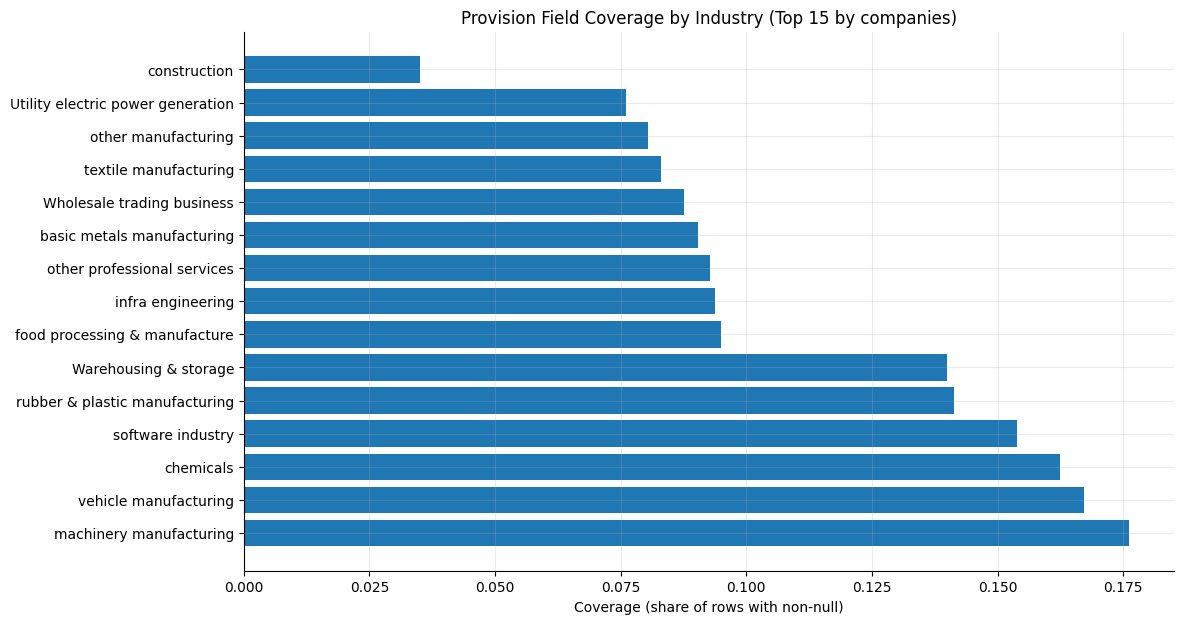

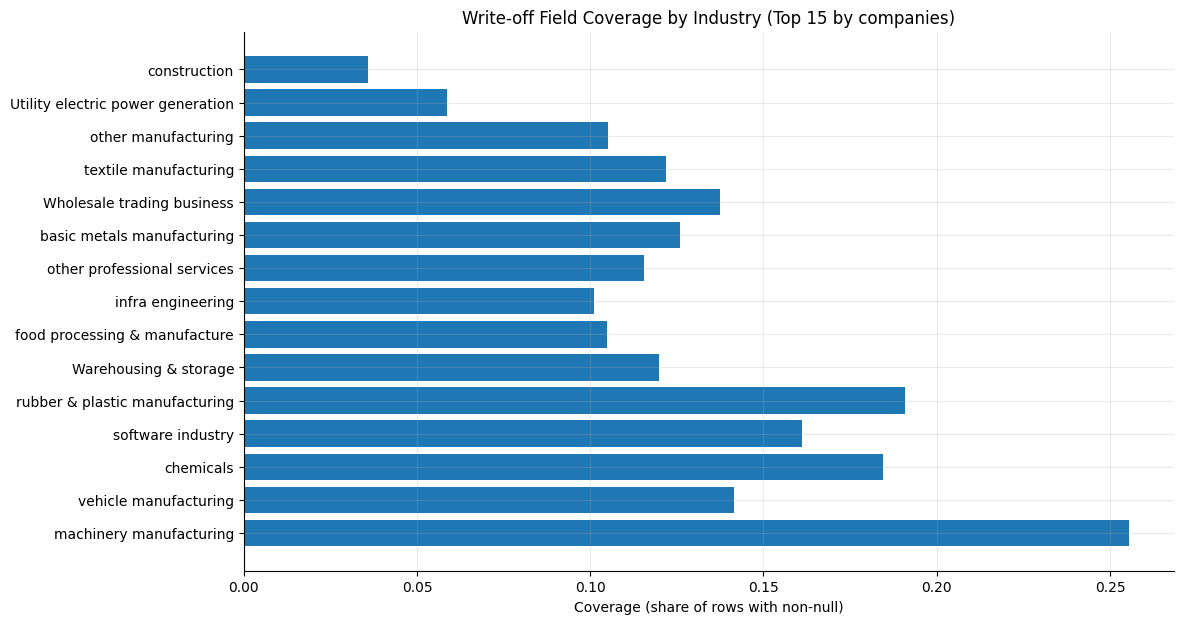

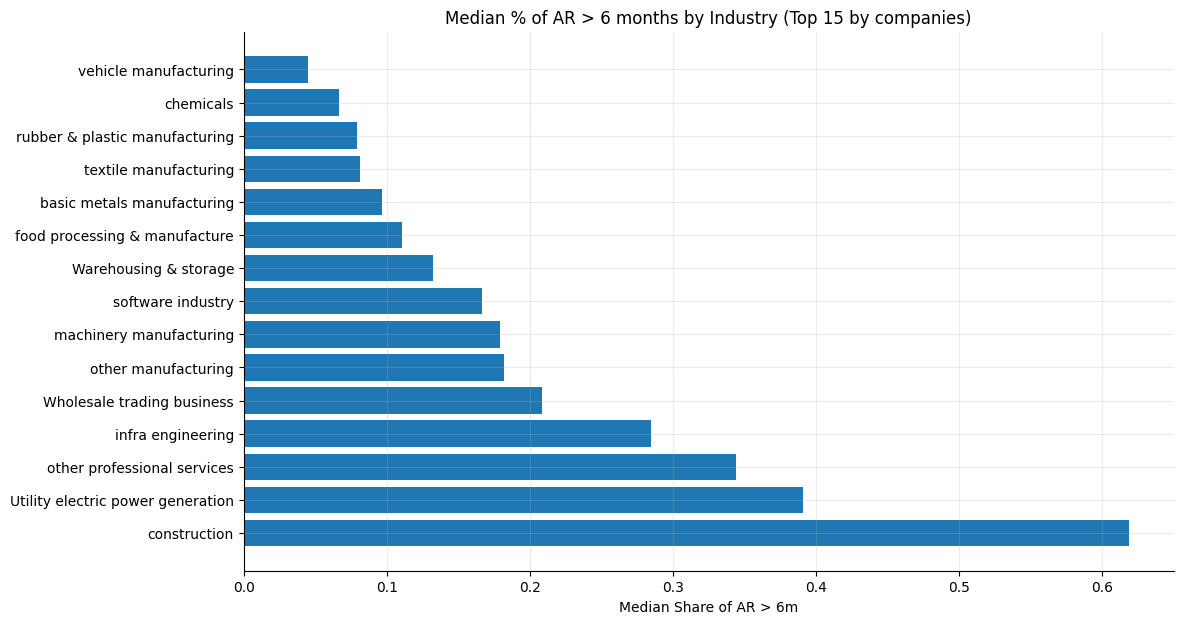

In [17]:
def savefig(name: str):
    out = ANALYSIS_DIR / name
    plt.tight_layout()
    plt.savefig(out, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Figure saved: {out}")

# 4.1 DSO distribution (using winsorized DSO, trimmed at 500 days)
dso_w = finite_series(df["dso_approx_w"])
dso_w = dso_w[(dso_w > 0) & (dso_w < 500)]
plt.figure()
plt.hist(dso_w.dropna(), bins=60)
plt.title("Distribution of DSO (winsorized; truncated at 500 days)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show("fig_dso_hist.png")

# 4.2 AR Turnover by Year (winsorized, boxplot, filtered)
turn_w = finite_series(df["ar_turnover_w"])
sub = df.loc[turn_w.between(0, 50, inclusive="neither"), ["year", "ar_turnover_w"]].dropna()
plt.figure()
sub.boxplot(column="ar_turnover_w", by="year")
plt.suptitle("")
plt.title("AR Turnover by Year (winsorized, 0 < x < 50)")
plt.xlabel("Year")
plt.ylabel("Turnover (times)")
plt.show("fig_ar_turnover_box_by_year.png")

# 4.3 Provisioning coverage by industry (top 15 industries by companies)
top_ind = (
    df.groupby("industry_name")["company_code"]
      .nunique()
      .sort_values(ascending=False)
      .head(15)
      .index
      .tolist()
)

cov = (
    df[df["industry_name"].isin(top_ind)]
      .groupby("industry_name")
      .agg(
          prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
          writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
      )
      .sort_values("prov_cov", ascending=False)
)

plt.figure()
plt.barh(cov.index, cov["prov_cov"])
plt.title("Provision Field Coverage by Industry (Top 15 by companies)")
plt.xlabel("Coverage (share of rows with non-null)")
plt.show("fig_provision_coverage_by_industry.png")

plt.figure()
plt.barh(cov.index, cov["writeoff_cov"])
plt.title("Write-off Field Coverage by Industry (Top 15 by companies)")
plt.xlabel("Coverage (share of rows with non-null)")
plt.show("fig_writeoff_coverage_by_industry.png")

# 4.4 Composition: Median % AR > 6 months by industry (top 15)
comp = (
    df[df["industry_name"].isin(top_ind)]
      .groupby("industry_name")
      .agg(med_pct_over6m=("pct_over6m", "median"))
      .sort_values("med_pct_over6m", ascending=False)
)
plt.figure()
plt.barh(comp.index, comp["med_pct_over6m"])
plt.title("Median % of AR > 6 months by Industry (Top 15 by companies)")
plt.xlabel("Median Share of AR > 6m")
plt.show("fig_pct_over6m_by_industry.png")


### **C. Diagnostic Analytics**

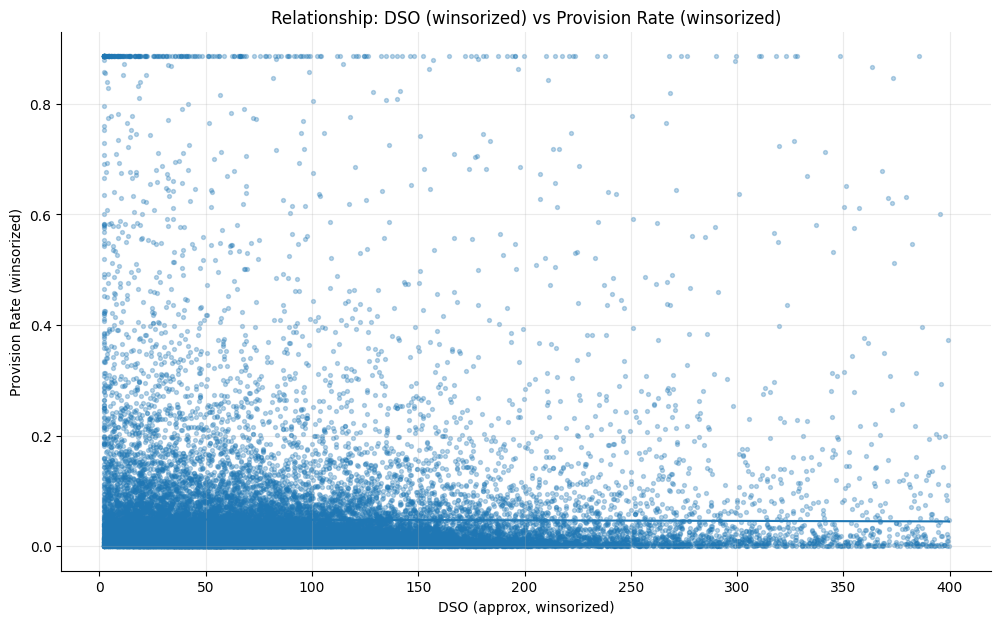

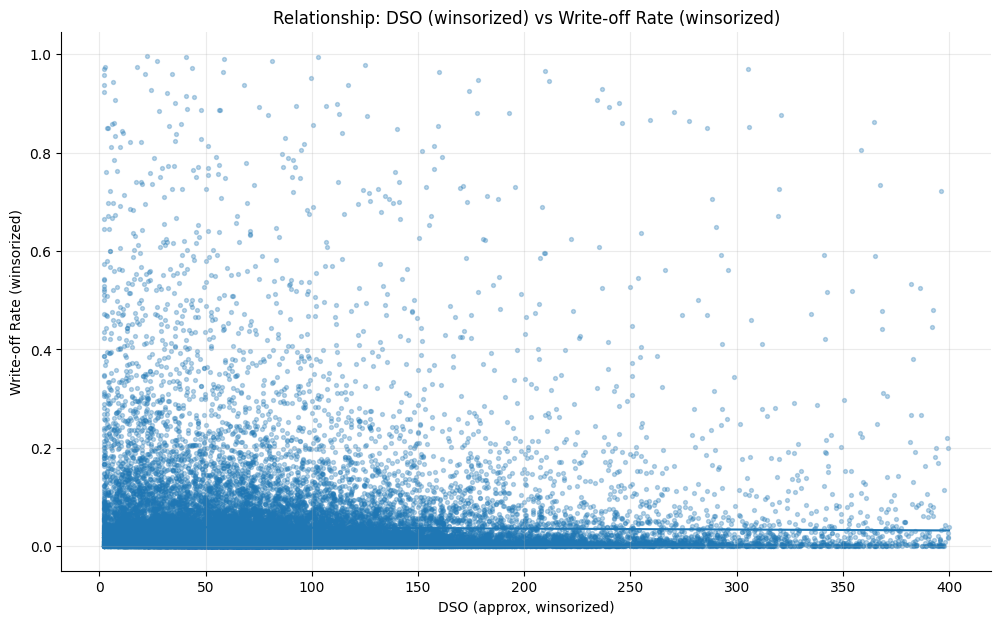

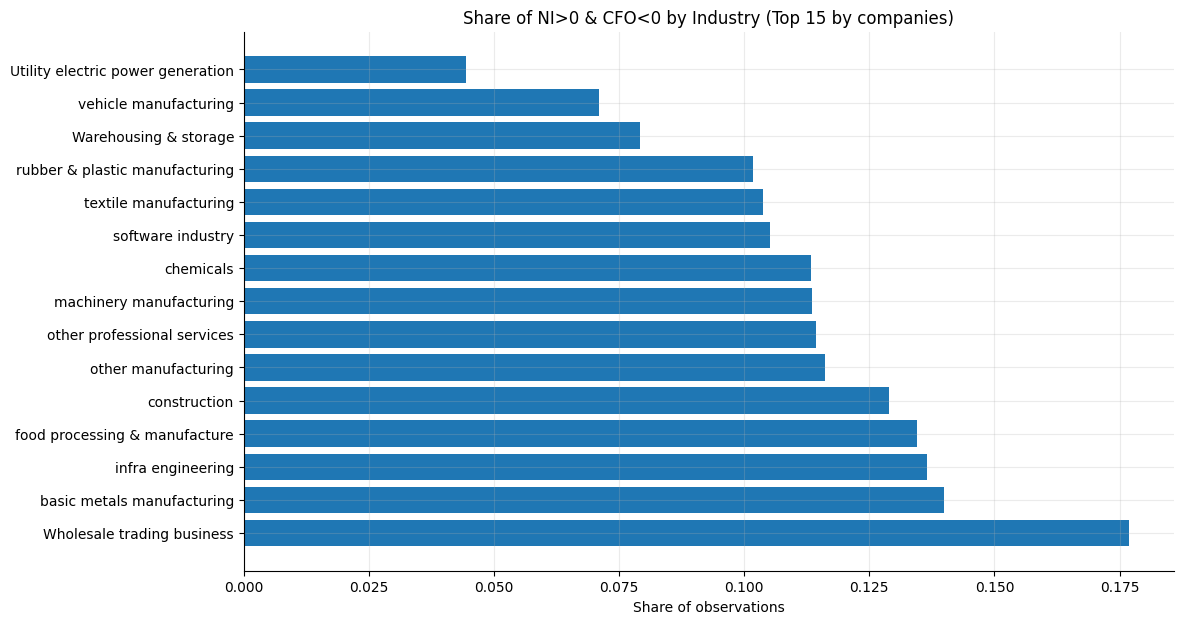

In [18]:
# 5.1 Scatter: DSO vs Provision Rate (winsorized, trimmed to sensible range)
tmp = df[["dso_approx_w", "prov_rate_w"]].copy()
tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna()
tmp = tmp[(tmp["dso_approx_w"] > 0) & (tmp["dso_approx_w"] < 400)]
# For clarity in the scatter, focus on provision rates in [0, 1)
tmp = tmp[(tmp["prov_rate_w"] >= 0) & (tmp["prov_rate_w"] < 1)]

plt.figure()
plt.scatter(tmp["dso_approx_w"], tmp["prov_rate_w"], s=8, alpha=0.3)
# Simple trendline
if len(tmp) > 50:
    m, b = np.polyfit(tmp["dso_approx_w"], tmp["prov_rate_w"], 1)
    x = np.linspace(tmp["dso_approx_w"].min(), tmp["dso_approx_w"].max(), 200)
    plt.plot(x, m * x + b)
plt.title("Relationship: DSO (winsorized) vs Provision Rate (winsorized)")
plt.xlabel("DSO (approx, winsorized)")
plt.ylabel("Provision Rate (winsorized)")
plt.show("fig_scatter_dso_vs_provrate.png")

# 5.2 Scatter: DSO vs Write-off Rate (winsorized)
tmp2 = df[["dso_approx_w", "writeoff_rate_w"]].copy()
tmp2 = tmp2.replace([np.inf, -np.inf], np.nan).dropna()
tmp2 = tmp2[(tmp2["dso_approx_w"] > 0) & (tmp2["dso_approx_w"] < 400)]
tmp2 = tmp2[(tmp2["writeoff_rate_w"] >= 0) & (tmp2["writeoff_rate_w"] < 1)]

plt.figure()
plt.scatter(tmp2["dso_approx_w"], tmp2["writeoff_rate_w"], s=8, alpha=0.3)
if len(tmp2) > 50:
    m, b = np.polyfit(tmp2["dso_approx_w"], tmp2["writeoff_rate_w"], 1)
    x = np.linspace(tmp2["dso_approx_w"].min(), tmp2["dso_approx_w"].max(), 200)
    plt.plot(x, m * x + b)
plt.title("Relationship: DSO (winsorized) vs Write-off Rate (winsorized)")
plt.xlabel("DSO (approx, winsorized)")
plt.ylabel("Write-off Rate (winsorized)")
plt.show("fig_scatter_dso_vs_writeoffrate.png")

# 5.3 Diagnostic: NI>0 & CFO<0 rate by industry (top 15)
neg_cash = (
    df[df["industry_name"].isin(top_ind)]
      .groupby("industry_name")["ni_pos_cfo_neg_flag"]
      .mean()
      .sort_values(ascending=False)
)
plt.figure()
plt.barh(neg_cash.index, neg_cash.values)
plt.title("Share of NI>0 & CFO<0 by Industry (Top 15 by companies)")
plt.xlabel("Share of observations")
plt.show("fig_nipos_cfoneg_by_industry.png")


### **J. Correlation heatmap and Exports**

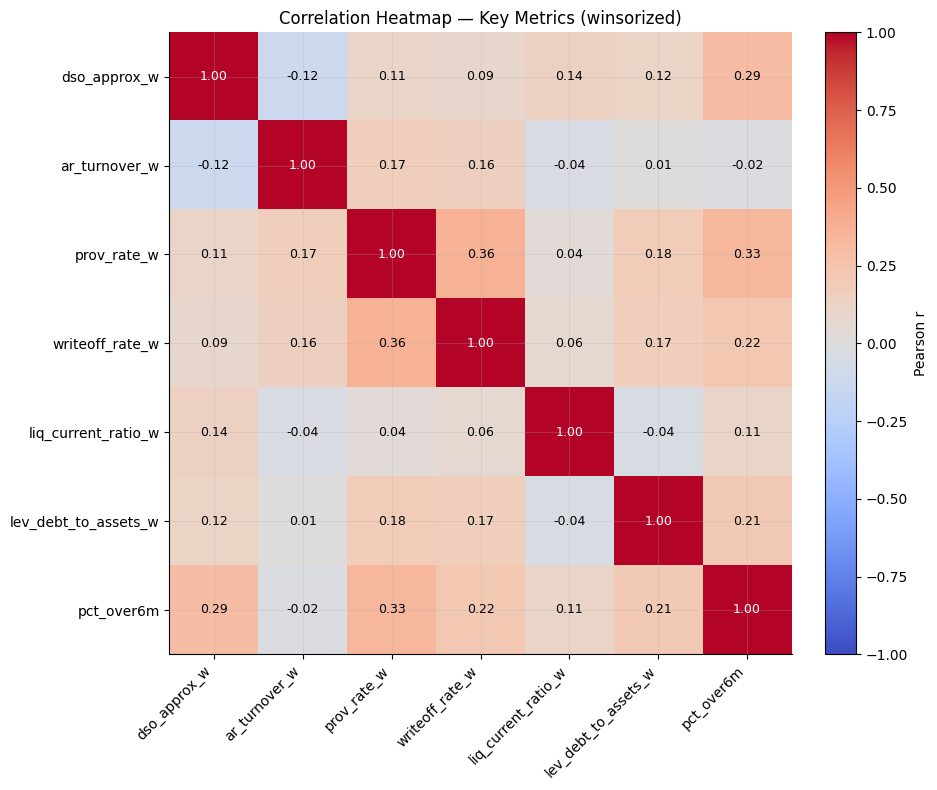

In [19]:
from matplotlib.colors import TwoSlopeNorm

# Correlation matrix across key metrics (winsorized)
corr_cols = [
    "dso_approx_w", "ar_turnover_w", "prov_rate_w", "writeoff_rate_w",
    "liq_current_ratio_w", "lev_debt_to_assets_w", "pct_over6m"
]

corr_df = (
    df[corr_cols]
      .replace([np.inf, -np.inf], np.nan)
      .corr(method="pearson")
)
corr_df.to_csv(ANALYSIS_DIR / "_corr_metrics.csv")

# Heatmap with blue↔white↔red gradient centered at 0
plt.figure(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
im = plt.imshow(corr_df.values, cmap="coolwarm", norm=norm)

# Ticks & labels
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)

# Annotate each cell with r (2 decimals)
n = len(corr_cols)
for i in range(n):
    for j in range(n):
        val = float(corr_df.values[i, j])
        text_color = "white" if abs(val) >= 0.6 else "black"
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=text_color)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Pearson r")

plt.title("Correlation Heatmap — Key Metrics (winsorized)")
plt.tight_layout()
plt.show("fig_corr_heatmap.png")


## ***IV. Analytics Questions & Answers***

### **A. Preconditions & helpers**
#### - Implement Settings
#### - Adds small helpers for clean displays & safe binning
#### - Load Cleaned Dataset

In [20]:
# ============
# 1) SETTINGS
# ============
BASE_DIR  = Path(r"F:\Master Resources\ACCT.745.01 - Acctg Info. & Analytics\Project 1\(1) Accounts Receivables Provision Data")
CLEAN_DIR = BASE_DIR / "_output_clean"
FACT_FILE = CLEAN_DIR / "_fact_cleaned_with_metrics.csv"  # core non-financial sample

# Console display prefs
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 25)

# Style
plt.rcParams.update({
    "figure.figsize": (11, 6),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

warnings.filterwarnings("ignore", category=RuntimeWarning)

# =====================
# 2) LOAD CLEANED DATA
# =====================
def load_fact(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(
            f"Cleaned file not found: {path}\n"
            f"Run the Cleaning, Transformation, and Summary script first."
        )
    df = pd.read_csv(path, low_memory=False)

    # Basic coercions / helpers
    df["year"] = pd.to_numeric(df.get("year"), errors="coerce")

    # Composition shares (if not already present)
    if "pct_over6m" not in df.columns and {"receivables_morethan6m", "accounts_receivables"}.issubset(df.columns):
        df["pct_over6m"]  = df["receivables_morethan6m"]  / df["accounts_receivables"]
        df["pct_under6m"] = df["receivables_lessthan6m"] / df["accounts_receivables"]

    # Flags to numeric
    df["ar_comp_ok_num"] = pd.to_numeric(df.get("ar_comp_ok"), errors="coerce")
    df["ni_pos_cfo_neg_flag"] = (
        pd.to_numeric(df.get("ni_pos_cfo_neg_flag"), errors="coerce")
        .fillna(0)
        .astype(int)
    )

    # Replace infs in key ratio columns (raw + winsorized where present)
    ratio_cols = [
        "dso_approx", "ar_turnover", "prov_rate", "writeoff_rate",
        "liq_current_ratio", "lev_debt_to_assets",
        "dso_approx_w", "ar_turnover_w", "prov_rate_w", "writeoff_rate_w",
        "liq_current_ratio_w", "lev_debt_to_assets_w",
        "pct_over6m", "pct_under6m",
    ]
    for c in ratio_cols:
        if c in df.columns:
            df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    return df


df = load_fact(FACT_FILE)


def finite(s: pd.Series) -> pd.Series:
    return s.replace([np.inf, -np.inf], np.nan)


def display_table(df_table: pd.DataFrame, title: str, rows: int = 15):
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))
    print(df_table.head(rows).to_string(index=False))
    

### **B — Q1: Which industries/years show atypical AR aging?**
#### - Computes Industry × Year medians (DSO, AR Turnover) + coverage
#### - Ranks industries by median DSO in the latest year
#### - Shows a quick bar chart of the 15 "oldest" industries


Q1 — 2022: Industries ranked by median DSO (higher = older)
                        industry_name    med_dso  med_pct_over6m  n_obs  n_companies  rank_dso_in_year
             Water & waste management 131.291794        0.564098     18           18               1.0
                          publishing  130.008061        0.225624     84           84               2.0
            video, audio broadcasting 119.702448        0.329989    174          174               3.0
                 real estate services 118.616881        0.199408     10           10               4.0
       public administration services 108.740659        0.339824     41           41               5.0
                     telecom services 100.027837        0.158418    260          260               6.0
                         construction  99.715016        0.884454   1350         1350               7.0
                       other services  99.533074        0.403802    144          144               8.0
          ot

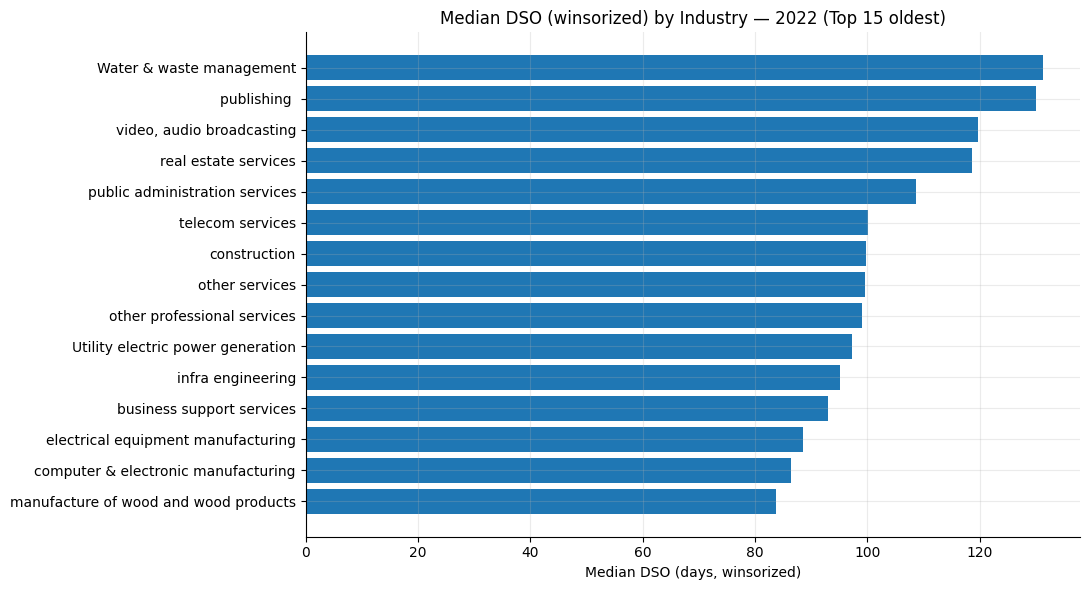

In [21]:
# Use winsorized DSO for the industry-year medians
q1 = (
    df.groupby(["industry_code", "industry_name", "year"], dropna=False)
      .agg(
          med_dso=("dso_approx_w", "median"),
          med_pct_over6m=("pct_over6m", "median"),
          n_obs=("company_code", "size"),
          n_companies=("company_code", "nunique"),
      )
      .reset_index()
)
q1["rank_dso_in_year"] = q1.groupby("year")["med_dso"].rank(method="min", ascending=False)

# Show: latest year top/bottom 10 industries by median DSO
latest_year = int(q1["year"].max())
q1_latest = q1[q1["year"] == latest_year].sort_values("med_dso", ascending=False)
display_table(
    q1_latest[
        ["industry_name", "med_dso", "med_pct_over6m", "n_obs", "n_companies", "rank_dso_in_year"]
    ],
    f"Q1 — {latest_year}: Industries ranked by median DSO (higher = older)",
)

# Figure: bar of top 15 oldest industries (latest year)
top15 = q1_latest.head(15)
plt.figure()
plt.barh(top15["industry_name"], top15["med_dso"])
plt.gca().invert_yaxis()
plt.title(f"Median DSO (winsorized) by Industry — {latest_year} (Top 15 oldest)")
plt.xlabel("Median DSO (days, winsorized)")
plt.tight_layout()
plt.show()

### **C — Q2: Do slower collections correlate with higher provisioning/write-offs?**
#### - Buckets into DSO deciles (robust to ties)
#### - Compares median provision/write-off rates across deciles
#### - Plots both lines across deciles


Q2 — DSO deciles vs median provision & write-off rates (winsorized)
dso_decile   n    med_dso  med_prov_rate  med_writeoff_rate
        D1 977  15.529852       0.023192           0.010197
        D2 977  33.462126       0.011749           0.005360
        D3 977  48.662812       0.010376           0.003941
        D4 976  61.112269       0.009933           0.004096
        D5 977  72.427374       0.009115           0.004480
        D6 977  84.448503       0.010359           0.004608
        D7 976  99.492996       0.010735           0.005624
        D8 977 119.060410       0.011986           0.006305
        D9 977 151.813782       0.013876           0.006059
       D10 977 228.346406       0.016582           0.006591


C:\Users\lilbu\AppData\Local\Temp\ipykernel_35292\3742877335.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q2.groupby("dso_decile")


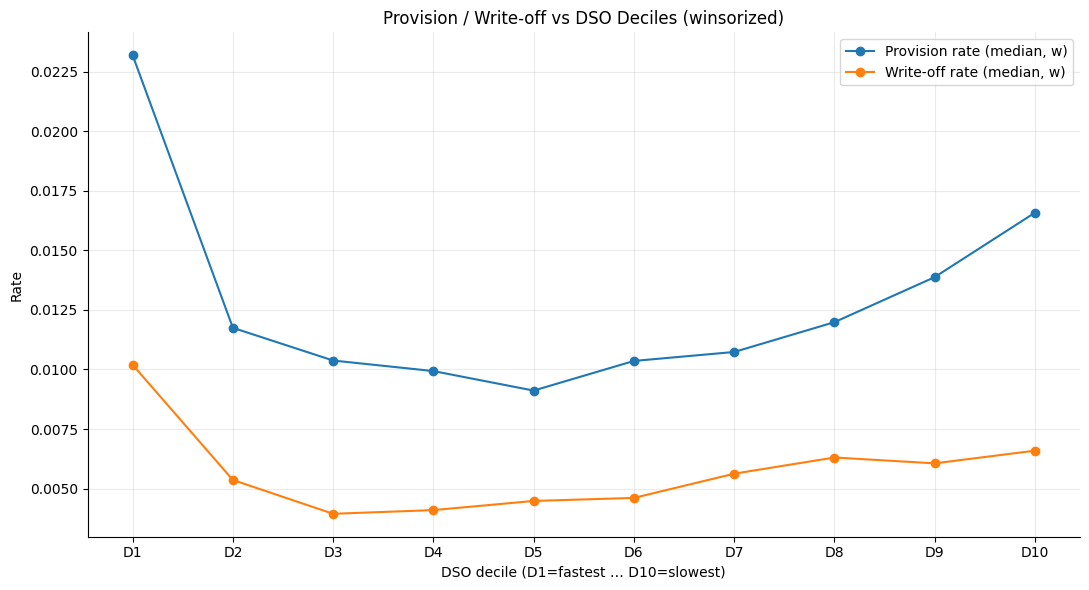

In [22]:
# Q2 — Do slower collections correlate with higher provisioning/write-offs?
# Use winsorized DSO and rates, trimmed to reasonable range
valid = df["dso_approx_w"].between(1, 400)
df_q2 = df.loc[valid, ["dso_approx_w", "prov_rate_w", "writeoff_rate_w"]].dropna()

if not df_q2.empty:
    df_q2["dso_decile"] = pd.qcut(
        df_q2["dso_approx_w"], 10, labels=[f"D{i}" for i in range(1, 11)]
    )

    q2 = (
        df_q2.groupby("dso_decile")
             .agg(
                 n=("dso_approx_w", "size"),
                 med_dso=("dso_approx_w", "median"),
                 med_prov_rate=("prov_rate_w", "median"),
                 med_writeoff_rate=("writeoff_rate_w", "median"),
             )
             .reset_index()
             .sort_values("med_dso")
    )
    display_table(
        q2, "Q2 — DSO deciles vs median provision & write-off rates (winsorized)", rows=10
    )

    # Figure: lines of provision & write-off vs DSO deciles
    plt.figure()
    plt.plot(
        q2["dso_decile"].astype(str),
        q2["med_prov_rate"],
        marker="o",
        label="Provision rate (median, w)",
    )
    plt.plot(
        q2["dso_decile"].astype(str),
        q2["med_writeoff_rate"],
        marker="o",
        label="Write-off rate (median, w)",
    )
    plt.title("Provision / Write-off vs DSO Deciles (winsorized)")
    plt.xlabel("DSO decile (D1=fastest … D10=slowest)")
    plt.ylabel("Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\nQ2 — Not enough valid observations after filtering to compute deciles.")

### **D — Q3: Is earnings quality weaker where collections lag?**
#### - Computes NI>0 & CFO<0 share across DSO deciles
#### - Ranks industries by that share

C:\Users\lilbu\AppData\Local\Temp\ipykernel_35292\3305453203.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q3.groupby("dso_decile")["ni_pos_cfo_neg_flag"]



Q3a — Share of NI>0 & CFO<0 by DSO decile (winsorized DSO)
dso_decile  share_nipos_cfoneg
        D1            0.134214
        D2            0.125107
        D3            0.124527
        D4            0.124254
        D5            0.127084
        D6            0.134427
        D7            0.141678
        D8            0.167235
        D9            0.183595
       D10            0.187527


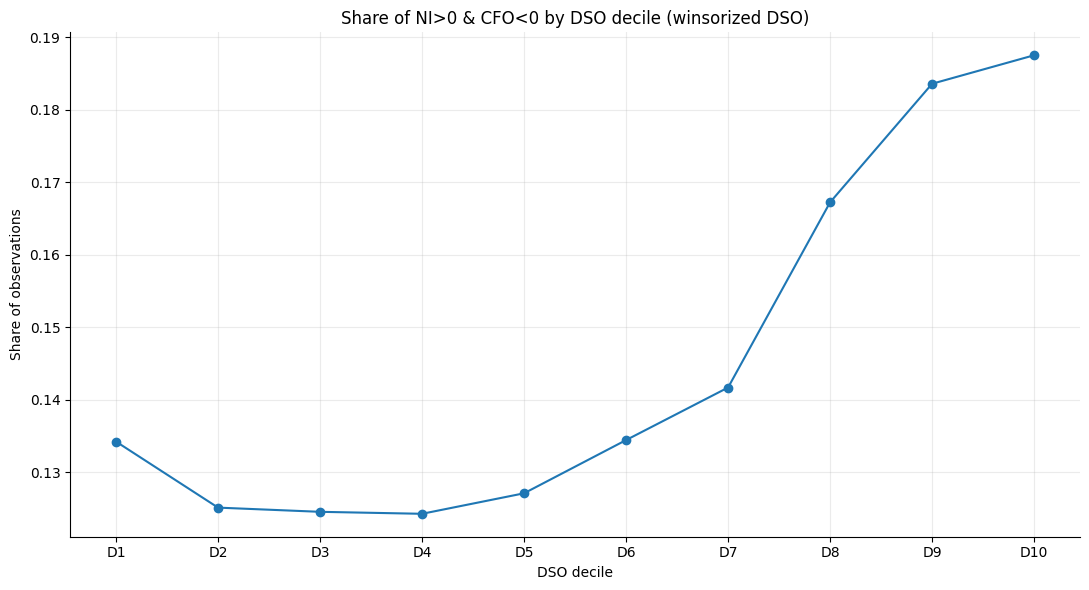


Q3b — Industries ranked by NI>0 & CFO<0 share
                      industry_name  share_nipos_cfoneg
         Wholesale trading business            0.176979
          automobile sale & service            0.163726
                   apparel industry            0.155428
                        Agriculture            0.152608
                 petroleum refinery            0.145985
 electrical equipment manufacturing            0.141522
         basic metals manufacturing            0.139992
            Retail trading business            0.137650
          video, audio broadcasting            0.137357
                  infra engineering            0.136623
      food processing & manufacture            0.134474
    fabricated metals manufacturing            0.132533
                       construction            0.128950
computer & electronic manufacturing            0.123175
                   leather industry            0.118407


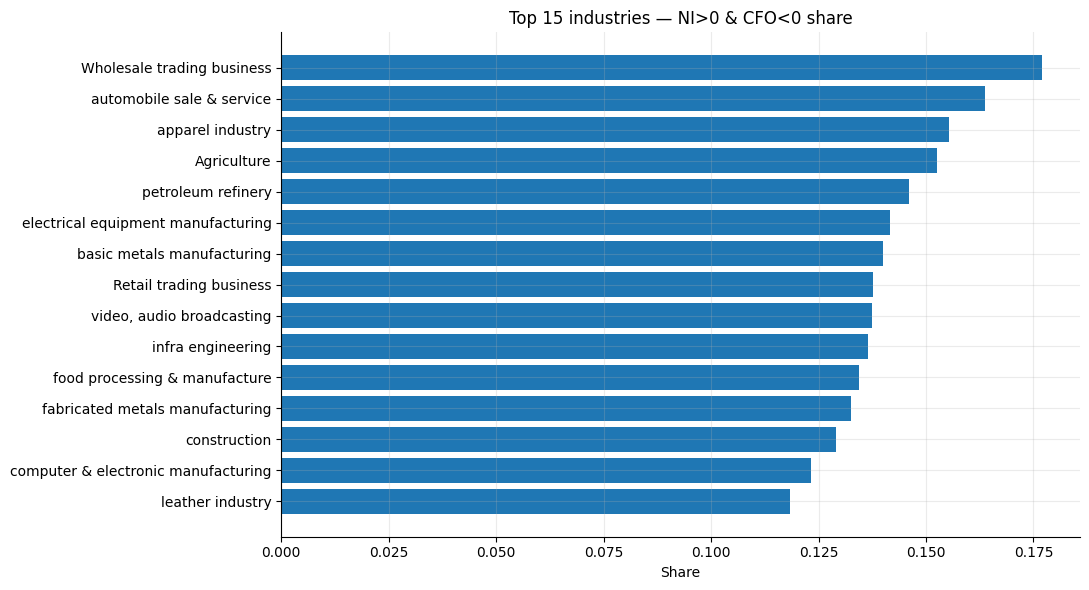

In [23]:
# Q3 — Is earnings quality weaker where collections lag?
df_q3 = df.loc[valid, ["dso_approx_w", "ni_pos_cfo_neg_flag", "industry_name"]].dropna()
if not df_q3.empty:
    df_q3["dso_decile"] = pd.qcut(
        df_q3["dso_approx_w"], 10, labels=[f"D{i}" for i in range(1, 11)]
    )

    q3a = (
        df_q3.groupby("dso_decile")["ni_pos_cfo_neg_flag"]
             .mean()
             .rename("share_nipos_cfoneg")
             .reset_index()
    )
    display_table(
        q3a,
        "Q3a — Share of NI>0 & CFO<0 by DSO decile (winsorized DSO)",
        rows=10,
    )

    # Figure: NI>0 & CFO<0 by DSO decile
    plt.figure()
    plt.plot(
        q3a["dso_decile"].astype(str),
        q3a["share_nipos_cfoneg"],
        marker="o",
    )
    plt.title("Share of NI>0 & CFO<0 by DSO decile (winsorized DSO)")
    plt.xlabel("DSO decile")
    plt.ylabel("Share of observations")
    plt.tight_layout()
    plt.show()
else:
    print("\nQ3 — Not enough valid observations after filtering to compute DSO deciles.")

q3b = (
    df.groupby("industry_name")["ni_pos_cfo_neg_flag"]
      .mean()
      .rename("share_nipos_cfoneg")
      .reset_index()
      .sort_values("share_nipos_cfoneg", ascending=False)
)
display_table(q3b, "Q3b — Industries ranked by NI>0 & CFO<0 share", rows=15)

# Figure: top 15 industries by NI>0 & CFO<0 share
plt.figure()
plt.barh(q3b.head(15)["industry_name"], q3b.head(15)["share_nipos_cfoneg"])
plt.gca().invert_yaxis()
plt.title("Top 15 industries — NI>0 & CFO<0 share")
plt.xlabel("Share")
plt.tight_layout()
plt.show()

### **E — Q4: Where are AR composition integrity issues concentrated?**
#### - Shows lowest pass rates by industry-year
#### - Lists companies with the highest failure rates


Q4a — Lowest AR composition integrity (industry-year)
                    industry_name  year  ar_comp_ok_rate
                 telecom services  2018         0.208904
                 telecom services  2021         0.216216
                 telecom services  2020         0.218519
                 telecom services  2019         0.219858
Utility electric power generation  2022         0.222609
                 telecom services  2022         0.226244
                 telecom services  2017         0.230000
Utility electric power generation  2021         0.238983
Utility electric power generation  2020         0.247078
Utility electric power generation  2019         0.259197
Utility electric power generation  2018         0.262697
Utility electric power generation  2017         0.310811
Mining, quarrying, and extraction  2022         0.350000
            Warehousing & storage  2022         0.356846
Mining, quarrying, and extraction  2021         0.366864


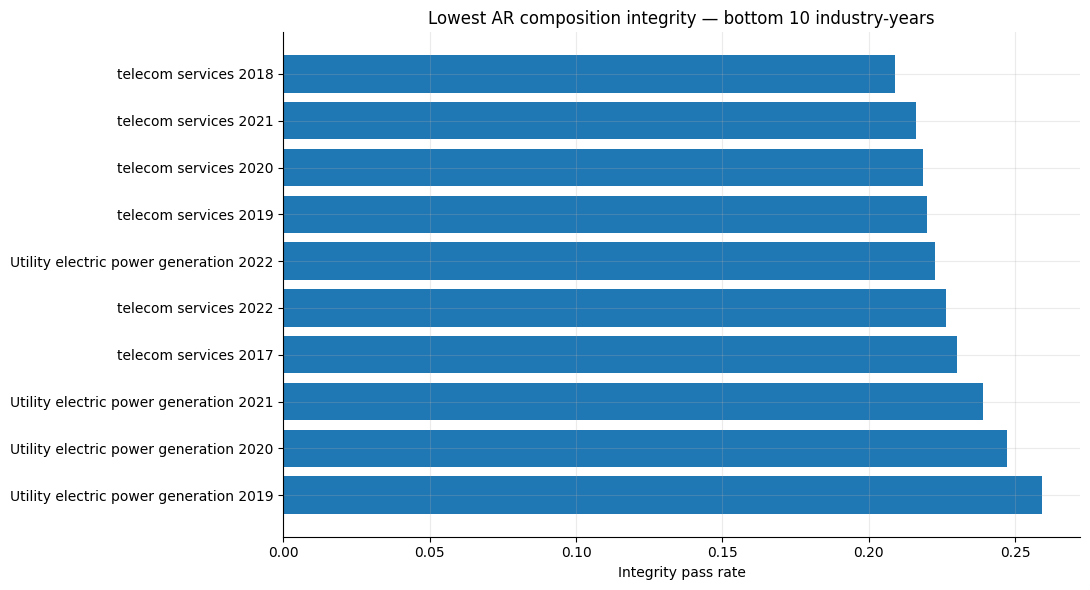


Q4b — Companies with highest AR composition failure rate
 company_code  ar_fail_rate
       353358           1.0
       666081           1.0
       788969           1.0
       788970           1.0
       788971           1.0
       471240           1.0
       348165           1.0
       510516           1.0
       510506           1.0
       644145           1.0
       666317           1.0
       666342           1.0
       666425           1.0
       223026           1.0
       510490           1.0
       644144           1.0
       510442           1.0
       480637           1.0
       644142           1.0
       666549           1.0


In [24]:
# Q4 — Where are AR composition integrity issues?
q4a = (
    df.groupby(["industry_name", "year"], dropna=False)["ar_comp_ok_num"]
      .mean()
      .rename("ar_comp_ok_rate")
      .reset_index()
)
# Bottom 15 industry-years by integrity
q4a_sorted = q4a.sort_values("ar_comp_ok_rate", ascending=True)
display_table(
    q4a_sorted,
    "Q4a — Lowest AR composition integrity (industry-year)",
    rows=15,
)

# Figure: bar of bottom 10
plt.figure()
tmp = q4a_sorted.head(10)
plt.barh(
    tmp["industry_name"] + " " + tmp["year"].astype(int).astype(str),
    tmp["ar_comp_ok_rate"],
)
plt.gca().invert_yaxis()
plt.title("Lowest AR composition integrity — bottom 10 industry-years")
plt.xlabel("Integrity pass rate")
plt.tight_layout()
plt.show()

# Company-level failure rate (top 20)
comp_fail = (
    df.assign(ar_fail=1 - pd.to_numeric(df["ar_comp_ok_num"], errors="coerce"))
      .groupby("company_code")["ar_fail"]
      .mean()
      .rename("ar_fail_rate")
      .reset_index()
      .sort_values("ar_fail_rate", ascending=False)
)
display_table(
    comp_fail,
    "Q4b — Companies with highest AR composition failure rate",
    rows=20,
)

### **F — Q5: What are the time trends in collection efficiency?**
#### - Year-over-year medians for DSO and AR Turnover
#### - Line charts for both


Q5 — Year-over-year trends: median DSO & AR turnover (winsorized)
 year   med_dso  med_ar_turnover  n_obs
 2012 67.230598         5.429076  20770
 2013 69.544277         5.248455  20450
 2014 67.356531         5.418925  22833
 2015 67.825658         5.381444  25602
 2016 71.326250         5.117331  27442
 2017 72.179124         5.056864  27918
 2018 74.481576         4.900541  29166
 2019 69.968660         5.216621  29016
 2020 70.359441         5.187648  28341
 2021 78.820811         4.630757  27783
 2022 67.386257         5.416535  25773


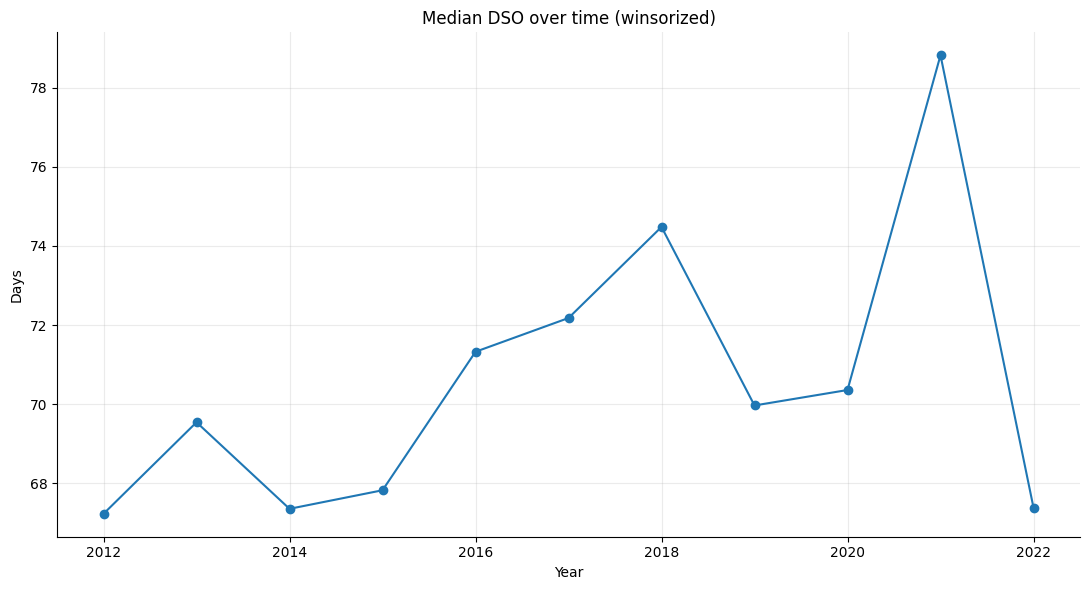

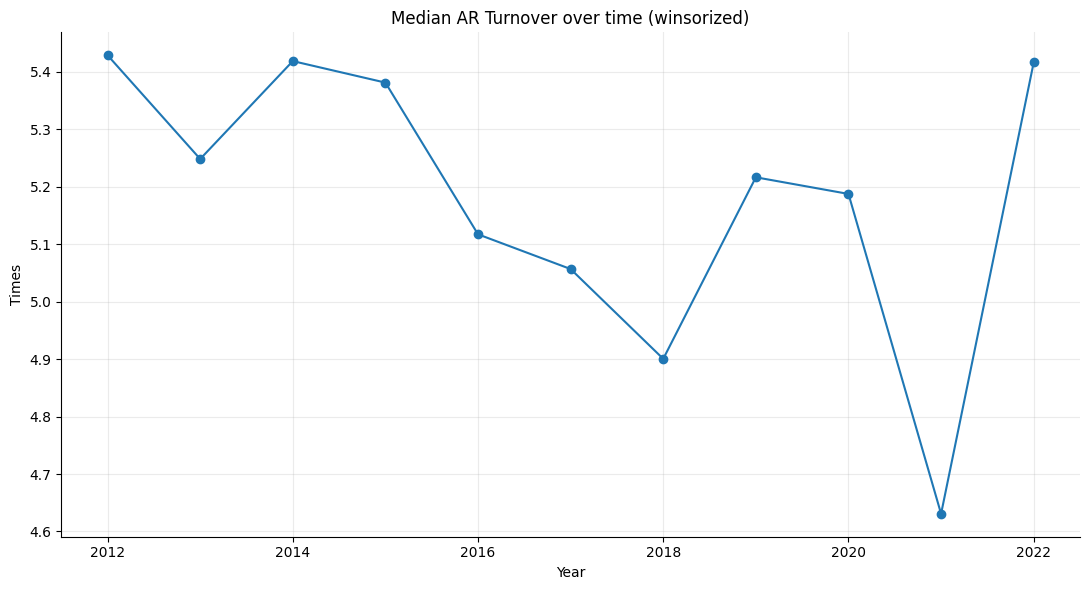

In [25]:
q5 = (
    df.groupby("year", dropna=False)
      .agg(
          med_dso=("dso_approx_w", "median"),
          med_ar_turnover=("ar_turnover_w", "median"),
          n_obs=("company_code", "size"),
      )
      .reset_index()
      .sort_values("year")
)
display_table(
    q5,
    "Q5 — Year-over-year trends: median DSO & AR turnover (winsorized)",
    rows=20,
)

# Figures: DSO and AR turnover trend lines
plt.figure()
plt.plot(q5["year"], q5["med_dso"], marker="o")
plt.title("Median DSO over time (winsorized)")
plt.xlabel("Year")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(q5["year"], q5["med_ar_turnover"], marker="o")
plt.title("Median AR Turnover over time (winsorized)")
plt.xlabel("Year")
plt.ylabel("Times")
plt.tight_layout()
plt.show()


### **G — Q6: How do liquidity and leverage relate to DSO?**
#### - Quartile-bins Current Ratio and Debt/Assets
#### - Compares median DSO across quartiles


Q6a — Median DSO (winsorized) by Current Ratio quartile
     liq_bin  median_dso     n
 CR Q1 (low)   54.103357 43327
       CR Q2   67.913684 43326
       CR Q3   74.432296 43326
CR Q4 (high)   81.185700 43327


C:\Users\lilbu\AppData\Local\Temp\ipykernel_35292\69039484.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_f.groupby("liq_bin")


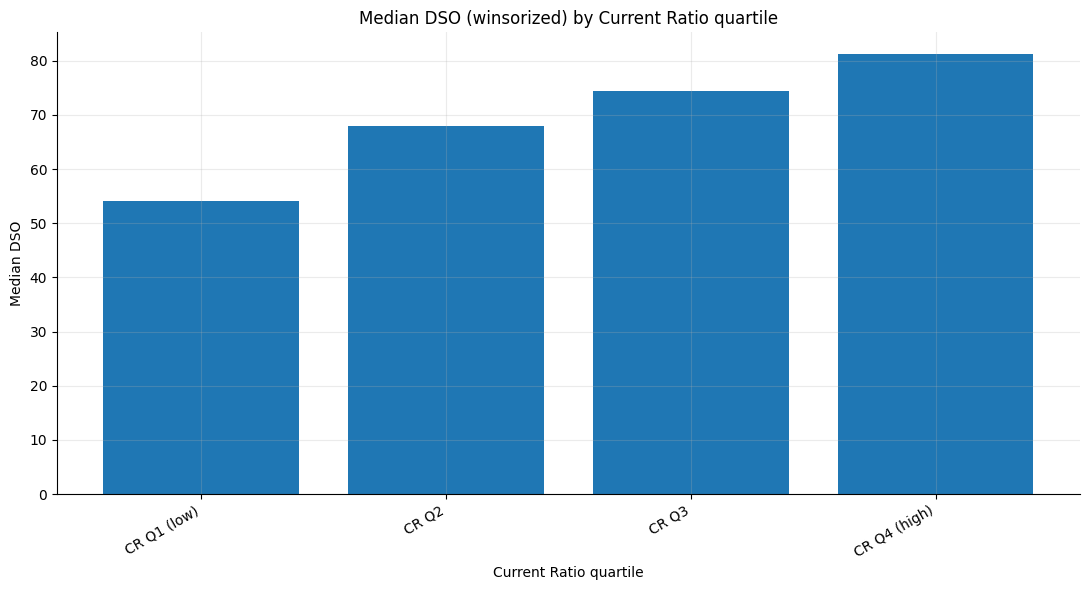


Q6b — Median DSO (winsorized) by Leverage (Debt/Assets) quartile
      lev_bin  median_dso     n
 Lev Q1 (low)   71.884465 43327
       Lev Q2   72.268094 43326
       Lev Q3   67.489978 43326
Lev Q4 (high)   67.508345 43327


C:\Users\lilbu\AppData\Local\Temp\ipykernel_35292\69039484.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_f.groupby("lev_bin")


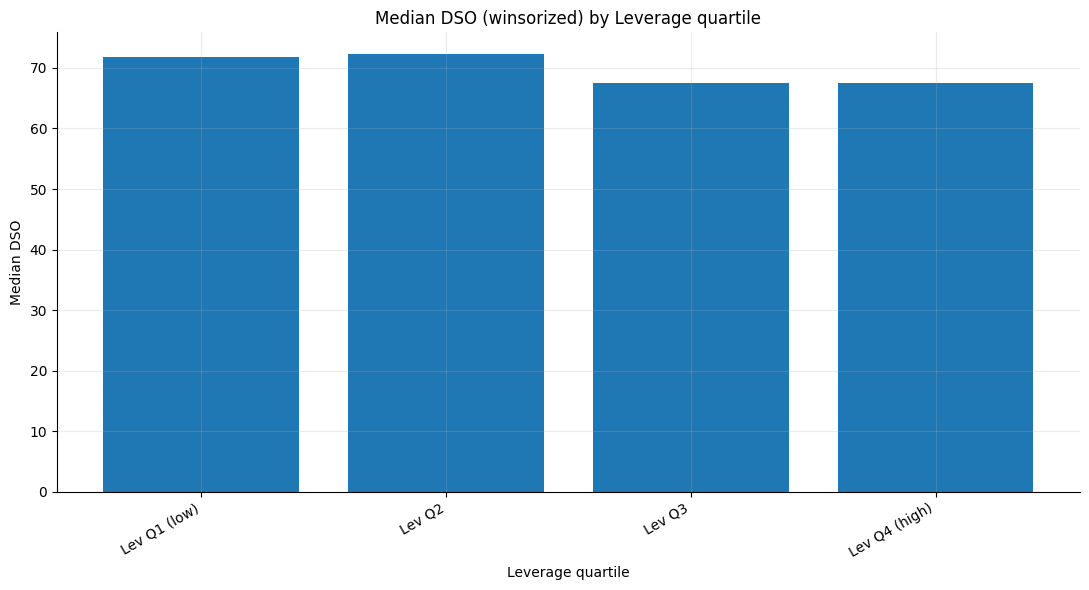

In [26]:
df_f = (
    df[["dso_approx_w", "liq_current_ratio_w", "lev_debt_to_assets_w"]]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

def quartile_bins(s, name):
    return pd.qcut(
        s,
        4,
        labels=[
            f"{name} Q1 (low)",
            f"{name} Q2",
            f"{name} Q3",
            f"{name} Q4 (high)",
        ],
    )

if not df_f.empty:
    df_f["liq_bin"] = quartile_bins(df_f["liq_current_ratio_w"], "CR")
    df_f["lev_bin"] = quartile_bins(df_f["lev_debt_to_assets_w"], "Lev")

    q6a = (
        df_f.groupby("liq_bin")
            .agg(
                median_dso=("dso_approx_w", "median"),
                n=("dso_approx_w", "size"),
            )
            .reset_index()
    )
    display_table(
        q6a,
        "Q6a — Median DSO (winsorized) by Current Ratio quartile",
        rows=10,
    )

    plt.figure()
    plt.bar(q6a["liq_bin"].astype(str), q6a["median_dso"])
    plt.title("Median DSO (winsorized) by Current Ratio quartile")
    plt.xlabel("Current Ratio quartile")
    plt.ylabel("Median DSO")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    q6b = (
        df_f.groupby("lev_bin")
            .agg(
                median_dso=("dso_approx_w", "median"),
                n=("dso_approx_w", "size"),
            )
            .reset_index()
    )
    display_table(
        q6b,
        "Q6b — Median DSO (winsorized) by Leverage (Debt/Assets) quartile",
        rows=10,
    )

    plt.figure()
    plt.bar(q6b["lev_bin"].astype(str), q6b["median_dso"])
    plt.title("Median DSO (winsorized) by Leverage quartile")
    plt.xlabel("Leverage quartile")
    plt.ylabel("Median DSO")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("\nQ6 — Not enough valid observations to compute liquidity/leverage quartiles.")

### **H — Q7: Which industries under-report provisioning/write-offs?**
#### - Coverage by industry-year
#### - Overall worst industries by average coverage


Q7 — Industries with lowest average provision coverage
                          industry_name  avg_prov_cov  avg_writeoff_cov  years
               Water & waste management      0.023522          0.051489     11
                           construction      0.035160          0.036254     11
      Utility electric power generation      0.075678          0.060754     11
manufacture of paper and paper products      0.078778          0.149671     11
                    other manufacturing      0.080749          0.105170     11
        fabricated metals manufacturing      0.082287          0.162093     11
                  textile manufacturing      0.083246          0.122241     11
                            Agriculture      0.085567          0.111463     11
             Wholesale trading business      0.086539          0.136316     11
             basic metals manufacturing      0.089660          0.126005     11
            other professional services      0.092843          0.115493    

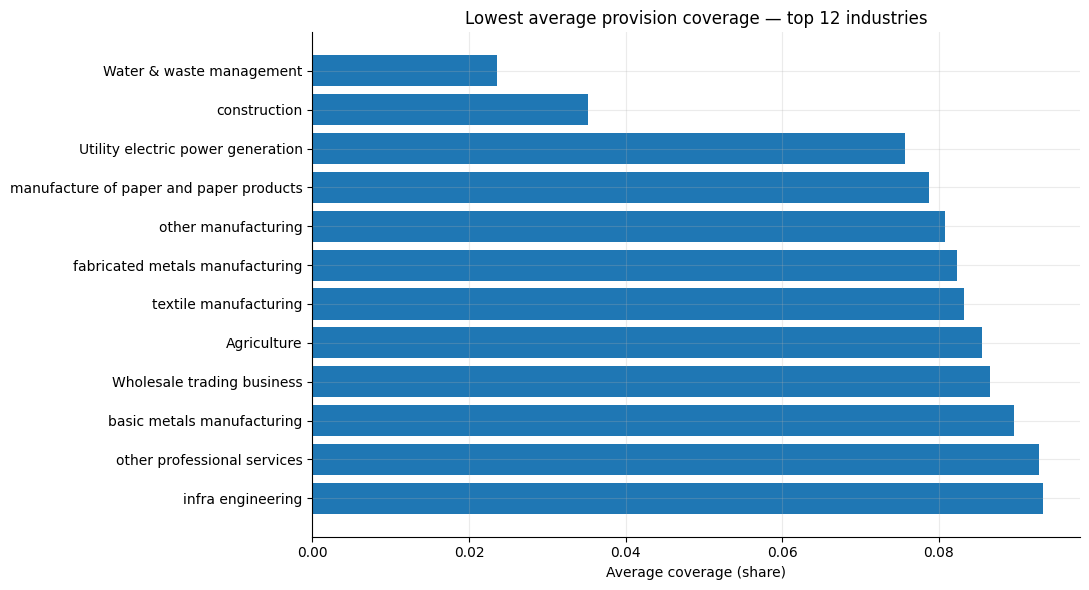

In [27]:
q7 = (
    df.groupby(["industry_name", "year"], dropna=False)
      .agg(
          prov_cov=("provision_bad_receivables", lambda s: s.notna().mean()),
          writeoff_cov=("writeoff_bad_receivables", lambda s: s.notna().mean()),
          n_obs=("company_code", "size"),
      )
      .reset_index()
)
# Worst average coverage across years
q7b = (
    q7.groupby("industry_name")
      .agg(
          avg_prov_cov=("prov_cov", "mean"),
          avg_writeoff_cov=("writeoff_cov", "mean"),
          years=("year", "nunique"),
      )
      .reset_index()
      .sort_values("avg_prov_cov")
)
display_table(q7b, "Q7 — Industries with lowest average provision coverage", rows=15)

plt.figure()
plt.barh(q7b.head(12)["industry_name"], q7b.head(12)["avg_prov_cov"])
plt.gca().invert_yaxis()
plt.title("Lowest average provision coverage — top 12 industries")
plt.xlabel("Average coverage (share)")
plt.tight_layout()
plt.show()

### **I — Q8: Who are standout fast/slow collectors in the latest year?**
#### - Lists 20 fastest and 20 slowest companies (median DSO) in the latest year, per industry mix
#### - Also shows a DSO histogram for the latest year


Q8 — 2022: Fastest collectors (lowest median DSO, winsorized)
                industry_name  company_code  dso_approx_w
      Retail trading business        668116      1.970386
           petroleum refinery        146009      1.970386
   Wholesale trading business        651642      1.970386
      Retail trading business        632213      1.970386
   Wholesale trading business        708566      1.970386
            infra engineering        459225      1.970386
      Retail trading business        353375      1.970386
food processing & manufacture        358062      1.970386
                    chemicals        273421      1.970386
                    chemicals        214348      1.970386
        Warehousing & storage        635476      1.970386
   basic metals manufacturing        481085      1.970386
   basic metals manufacturing        461484      1.970386
   basic metals manufacturing        471830      1.970386
                    chemicals        115246      1.970386
         

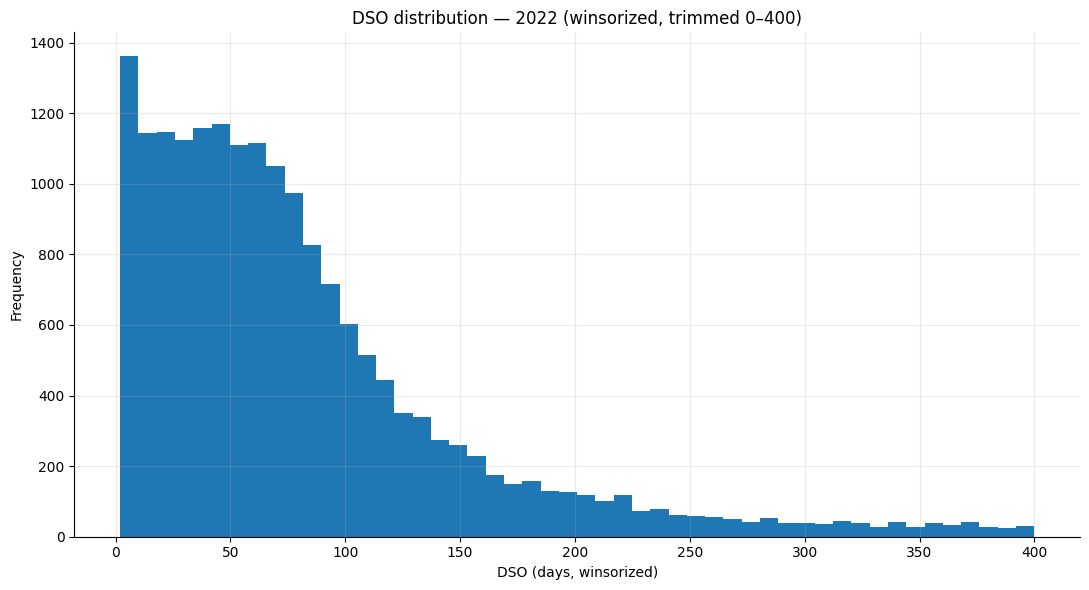

In [28]:
df_latest = df[df["year"] == latest_year].copy()
mask_latest = (df_latest["dso_approx_w"] > 0) & (df_latest["dso_approx_w"] < 400)

fast = (
    df_latest.loc[mask_latest]
             .groupby(["industry_name", "company_code"])["dso_approx_w"]
             .median()
             .reset_index()
             .sort_values("dso_approx_w")
             .head(20)
)
slow = (
    df_latest.loc[mask_latest]
             .groupby(["industry_name", "company_code"])["dso_approx_w"]
             .median()
             .reset_index()
             .sort_values("dso_approx_w", ascending=False)
             .head(20)
)

display_table(
    fast,
    f"Q8 — {latest_year}: Fastest collectors (lowest median DSO, winsorized)",
    rows=20,
)
display_table(
    slow,
    f"Q8 — {latest_year}: Slowest collectors (highest median DSO, winsorized)",
    rows=20,
)

# Figure: DSO histogram (latest year, winsorized)
plt.figure()
dso_latest = df_latest.loc[mask_latest, "dso_approx_w"].dropna()
plt.hist(dso_latest, bins=50)
plt.title(f"DSO distribution — {latest_year} (winsorized, trimmed 0–400)")
plt.xlabel("DSO (days, winsorized)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()